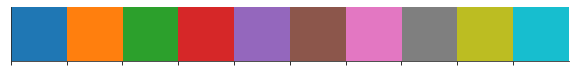

In [1]:
%load_ext autoreload
%autoreload 2
%run __init__
rs2_path = path['RSRCH'](4)

cache_path = './cache/e004'
try:
    os.mkdir(cache_path)
except:
    pass

fig_path = './figures/e004'
try:
    os.mkdir(fig_path)
except:
    pass

import importlib
e002_PLV = importlib.import_module('e002-ANK-Wavelet')
e004_NTF = importlib.import_module('e004-ANK-NTF_LDS')
e001_LL = importlib.import_module('e001-ANK-Line_Length')

stdout_orig = sys.stdout

flatui = ["#46637f", "#2ecc71", "#e74c3c", "#3498db", "#9b59b6", "#95a5a6"]
sns.palplot(sns.color_palette("tab10"))
sns.set_palette("tab10")

import statsmodels.formula.api as smf
import statsmodels
from scipy.special import expit

In [2]:
df_npref = path['CORE']['RNS']['NP_Ref']
df_ctlg = path['CORE']['RNS']['CATALOG']
TOD_DAYTIME = (7, 19)
BASELINE_DAY = 90

# Model Temporal Expression

## Function Definitions

In [3]:
#####
def combine_temporal_features(np_code, rank, despiked):
    
    ###
    key_dates = extract_key_dates(np_code)

    #####    
    df_count = utils.neuropaceIO.get_hourly_data_dict(path['CORE']['RNS']['HOURLY'][np_code])[['episode_starts_with_rx', 'long_episodes']]
    df_count = df_count.reset_index().rename(columns={'Raw UTC Timestamp': 'Timestamp'})

    W_time, W_freq, W_conn, n_exclude = e004_NTF.resample_NTF(np_code, metric='BIC', rank=rank, remove_blank=True, despiked=despiked)      
    W_time = W_time.drop(columns='Filename').reset_index()

    W_LL, n_exclude = e001_LL.resample_LL(np_code, remove_blank=True)        
    W_LL = W_LL[['CoVR']].rename(columns={'CoVR': 'LL_mean'}).reset_index().rename(columns={'Raw UTC Timestamp': 'Timestamp'})

    XX = pd.merge(W_time, W_LL, on='Timestamp').append(df_count).set_index('Timestamp')
    
    # Resample temporal data
    X = XX.loc[XX.index >= key_dates[0]] 
    X = X.set_index(X.index - key_dates[0])            
    X0 = np.nan*X.iloc[[0]]
    X0.index = [pd.Timedelta('0D')]
    X1 = X0.append(X).resample('1D').mean()
    X1['Tx_Current_Dose'] = X0.append(X).resample('1D').sum()['episode_starts_with_rx']
    X1['Dx_Current_LE'] = X0.append(X).resample('1D').sum()['long_episodes']

    return X1

#####
def time_of_day_temporal_expression(np_code):
    
    ###
    key_dates = extract_key_dates(np_code)

    XX, _, _, _ = e004_NTF.resample_NTF(np_code, metric='BIC', rank=3, remove_blank=True, despiked=despiked)      
    XX = XX.drop(columns='Filename')
    XX[['Fac_0', 'Fac_1', 'Fac_2']] = XX[['Fac_0', 'Fac_1', 'Fac_2']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # Resample temporal data
    X = XX.loc[XX.index >= key_dates[0]].dropna()
    X_daytime = X.loc[(((X.index.hour) >= TOD_DAYTIME[0]) & 
                       ((X.index.hour) < TOD_DAYTIME[1]))].dropna().mean()
    X_nighttime = X.loc[~(((X.index.hour) >= TOD_DAYTIME[0]) & 
                         ((X.index.hour) < TOD_DAYTIME[1]))].dropna().mean()   

    return X_daytime, X_nighttime


#####
def plot_cumulative_therapy(np_code, cumul_days):
    
    X1 = combine_temporal_features(np_code, rank=3, despiked=False)
    fac_col = np.array([col for col in X1.columns if 'Fac' in col])

    WCE_fn = lambda x: np.exp(-np.arange(1e4)/x)  
    WCE = WCE_fn(cumul_days) 
    X1['Tx_WCE_Dose'] = np.convolve(X1['Tx_Current_Dose'], WCE, mode='full')[:len(X1)]

    X = X1.copy()    
    X = X.interpolate(limit_direction='both')
    X[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']] = X[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']].resample('1D').mean().rolling('360D').mean()
    X[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']] = X[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X = X.set_index(X.index.days).reset_index().rename(columns={'index': 'time'})
    
    return X


def plot_long_episodes(np_code, stable_date, tscale, max_lags):
    ###########
    print('\n\n', np_code, flush=True)

    ###
    key_dates = extract_key_dates(np_code)
    stable_days = stable_date - key_dates[0]
    print(stable_days)

    # Remove observations preceding stable long-episodes parameters    
    X1 = combine_temporal_features(np_code, rank=3, despiked=False)
    X1 = X1.set_index(X1.index - stable_days.iloc[0])
    X1.loc[X1.index < pd.Timedelta('0 days'), 'Dx_Current_LE'] = np.nan
    X1 = X1[X1.index >= pd.Timedelta('{} days'.format(-1*max_lags*tscale))]

    fac_col = np.array([col for col in X1.columns if 'Fac' in col])

    X = X1.copy()    
    X11 = X[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']].resample('1D').mean().rolling('{}D'.format(tscale)).mean()
    X11 = X11[['Fac_0', 'Fac_1', 'Fac_2', 'LL_mean']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X22 = X[['Dx_Current_LE']].resample('1D').sum() #.rolling('{}D'.format(tscale)).apply(lambda x: sum()
    X22.loc[X22.index < pd.Timedelta('0 days'), 'Dx_Current_LE'] = np.nan
    X22['Dx_Current_LE'] = np.convolve(X22['Dx_Current_LE'], np.ones(tscale)/tscale, mode='full')[tscale-1:] #[:len(X22)]
    
    X11 = X11.set_index(X11.index.days).reset_index().rename(columns={'index': 'time'})
    X22 = X22.set_index(X22.index.days).reset_index().rename(columns={'index': 'time'})
    
    return X11, X22


#####
def fit_counts(pred_name, X, feats):
    formula_null = '{} ~ 1'.format(pred_name)
    formula = '{} ~ 1 + {}'.format(pred_name, '+'.join(feats))

    try:
        mdl_po = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()
        mdl_po_null = smf.glm(formula=formula_null, data=X, family=sm.families.Poisson()).fit() 

        R2 = 1 - mdl_po.deviance / mdl_po_null.deviance
        beta_fac = np.array(mdl_po.params[feats[:-1]].values)
        beta_LL = np.array(mdl_po.params[[feats[-1]]].values)
    
    except Exception as E:
        R2 = np.nan
        beta_fac = np.array((len(feats)-1)*[np.nan])
        beta_LL = np.array([np.nan])
    
    return R2, beta_fac, beta_LL

#####
def fit_longeps(Y_names, X_names, X):
    formula_null = '{} ~ 1'.format(Y_names)
    formula = '{} ~ 1 + {}'.format(Y_names, X_names)
    
    mdl_po = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()
    mdl_po_null = smf.glm(formula=formula_null, data=X, family=sm.families.Poisson()).fit() 
    
    return mdl_po, mdl_po_null

## Cumulative Stimulation Model

#### Plot

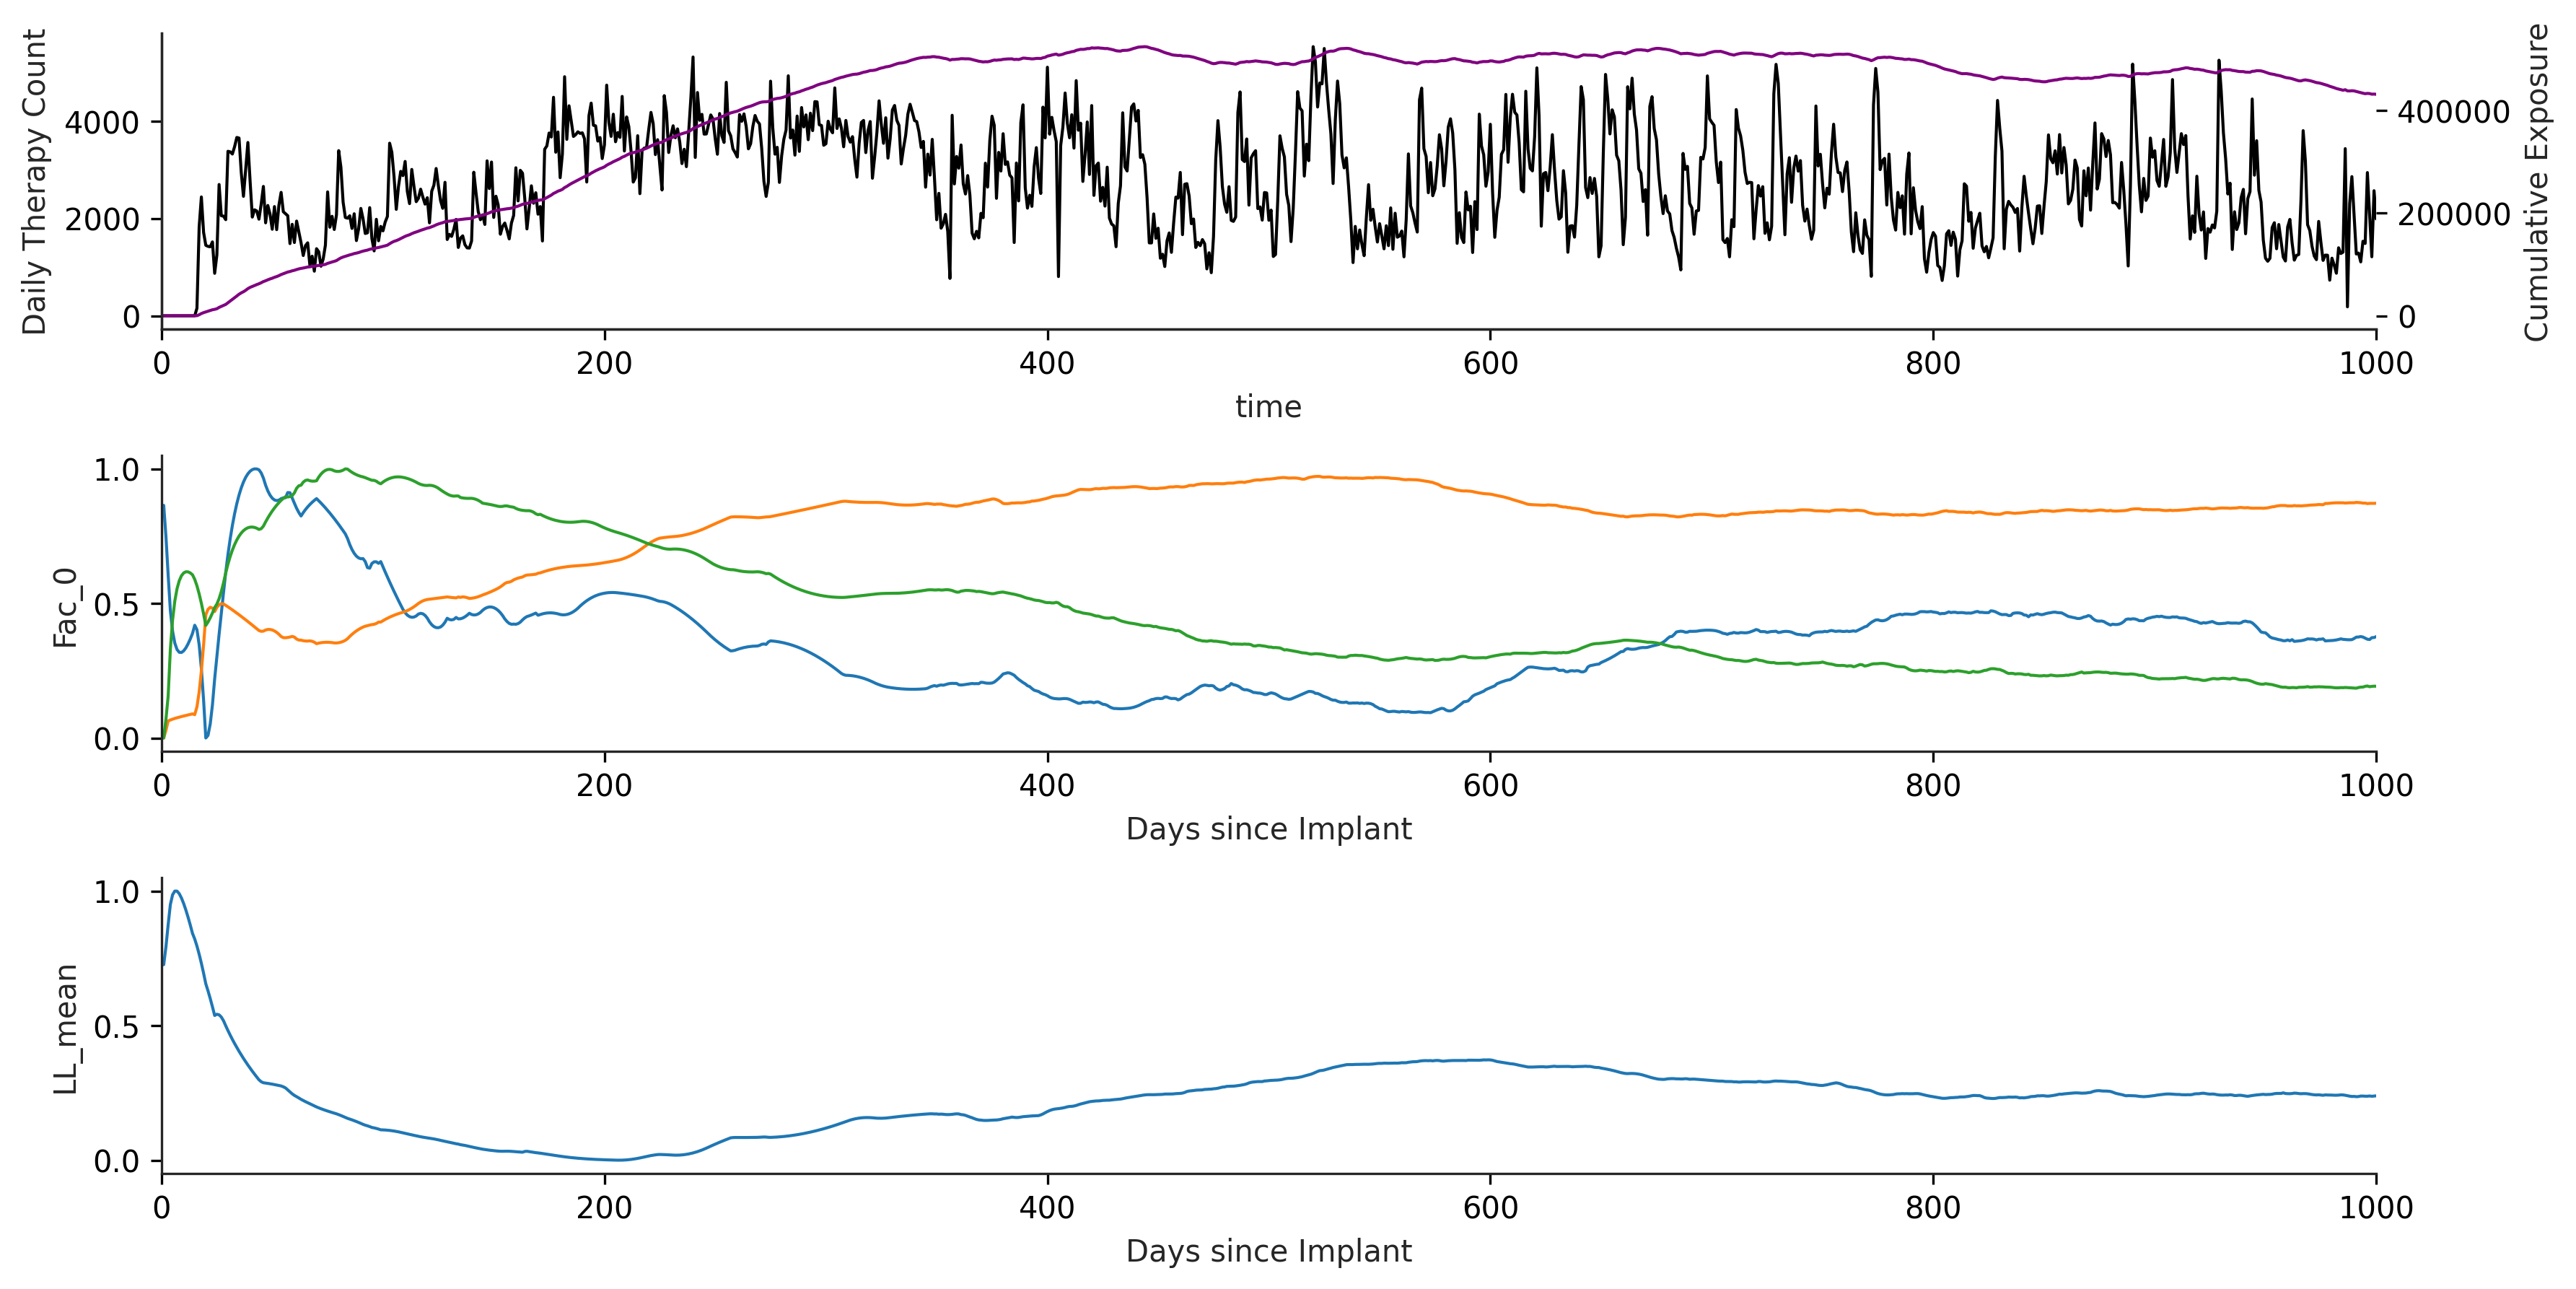

In [19]:
###
np_code = 'NP5'
cumul_days = 180
X = plot_cumulative_therapy(np_code, cumul_days)

plt.figure(figsize=(12,6), dpi=300)

ax1 = plt.subplot(3,1,1)
ax1 = sns.lineplot(x='time', y='Tx_Current_Dose', linewidth=1, color='k', data=X, ax=ax1)
ax1.set_ylabel('Daily Therapy Count')

ax2 = ax1.twinx()
ax2 = sns.lineplot(x='time', y='Tx_WCE_Dose', linewidth=1, color='purple', data=X, ax=ax2)
ax2.set_ylabel('Cumulative Exposure')
ax2.set_xlabel('Days since Implant')

ax3 = plt.subplot(3,1,2, sharex=ax2)
ax3 = sns.lineplot(x='time', y='Fac_0', linewidth=1, data=X, ax=ax3)
ax3 = sns.lineplot(x='time', y='Fac_1', linewidth=1, data=X, ax=ax3)
ax3 = sns.lineplot(x='time', y='Fac_2', linewidth=1, data=X, ax=ax3)
ax3.set_xlabel('Days since Implant')

ax4 = plt.subplot(3,1,3, sharex=ax2)
ax4 = sns.lineplot(x='time', y='LL_mean', linewidth=1, data=X, ax=ax4)
ax4.set_xlabel('Days since Implant')

ax3.set_xlim(xmin=0, xmax=1000)

plt.tight_layout()
plt.savefig('{}/Cumulative_Effect-{}_{}days.svg'.format(fig_path, np_code, cumul_days))
plt.show()

### Build Model

In [12]:
# Grab data for NP_code    
X_NTF_Subject = {}
rank=3
despiked=False

# Baseline Period
for np_code in df_npref['NP_code'].unique():
    print(np_code)

    X1 = combine_temporal_features(np_code, rank=rank, despiked=despiked)
    if X1['Tx_Current_Dose'].sum() == 0:
        continue
            
    fac_col = np.array([col for col in X1.columns if 'Fac' in col])
    mdl_dict = {'model_name': [],
                'Cumulative_Days': [],
                'R2': [],
                'beta-LL_mean': [],             
                'NP_code': []}
    for rnk in range(rank):
        mdl_dict['beta-Fac_{}'.format(rnk)] = []
    
    for cumul_days in np.array([0, 1, 2, 3, 4, 7, 14, 30, 90, 180, 360, 720]):

        if cumul_days > 0:
            WCE_fn = lambda x: np.exp(-np.arange(1e4)/x) / np.exp(-np.arange(1e4)/x).sum()   
            WCE = WCE_fn(cumul_days) 
            X1['Tx_WCE_Dose'] = np.convolve(X1['Tx_Current_Dose'], WCE, mode='full')[:len(X1)]
        else:
            X1['Tx_WCE_Dose'] = X1['Tx_Current_Dose']

        X = X1.copy()
        X = X.dropna()
        X = X.set_index(X.index.days).reset_index()
        X = X.rename(columns={'index': 'time'})

        feat_col = ['LL_mean']
        for rnk in range(rank):
            feat_col.append('Fac_{}'.format(rnk))
        X[feat_col] = X[feat_col].apply(lambda x: sp_stats.zscore(x))
        X['Tx_WCE_Dose_R'] = X['Tx_WCE_Dose'].copy()

        for pred_name in ['Tx_WCE_Dose',
                          'Tx_WCE_Dose_R']:

            if pred_name == 'Tx_WCE_Dose_R':
                beta_fac = np.array(rank*[np.nan])
                beta_LL = np.array([np.nan])
                for rnd in range(100):
                    XT = X.copy()
                    XT[feat_col] = XT[feat_col].sample(frac=1).values
                    R2, beta_fac, beta_LL = fit_counts(pred_name, XT, feat_col)
                        
                    ###
                    mdl_dict['NP_code'].append(np_code)            
                    mdl_dict['model_name'].append(pred_name)
                    mdl_dict['Cumulative_Days'].append(cumul_days)
                    mdl_dict['R2'].append(R2)
                    for rnk in range(rank):
                        mdl_dict['beta-Fac_{}'.format(rnk)].append(beta_fac[rnk])
                    mdl_dict['beta-LL_mean'].append(beta_LL[0])
                    
            else:
                R2, beta_fac, beta_LL = fit_counts(pred_name, X, feat_col)
                
                ###
                mdl_dict['NP_code'].append(np_code)            
                mdl_dict['model_name'].append(pred_name)
                mdl_dict['Cumulative_Days'].append(cumul_days)
                mdl_dict['R2'].append(R2)
                for rnk in range(rank):
                    mdl_dict['beta-Fac_{}'.format(rnk)].append(beta_fac[rnk])
                mdl_dict['beta-LL_mean'].append(beta_LL[0])

    df_model = pd.DataFrame.from_dict(mdl_dict).set_index('NP_code')

    ###
    if 'model' not in X_NTF_Subject:
        X_NTF_Subject['model'] = []
    X_NTF_Subject['model'].append(df_model)

X_NTF_Subject['model'] = pd.concat(X_NTF_Subject['model'], axis=0)
X_NTF_Subject['model'].to_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))

NP1
NP2
NP3
NP4
NP5
NP6
NP7
NP9
NP10
NP11
NP12
NP13
NP14
NP15
NP16
NP17
NP18
NP19
NP55
NP20
NP21
NP22
NP23
NP24
NP25
NP26
NP27
NP28
NP29
NP30
NP31
NP33
NP32
NP34
NP35
NP36
NP37
NP38
NP39
NP41
NP40
NP42
NP43
NP44
NP45
NP46
NP47
NP48
NP49
NP50
NP51


### Trajectory

FDA-pvalue: 0.018


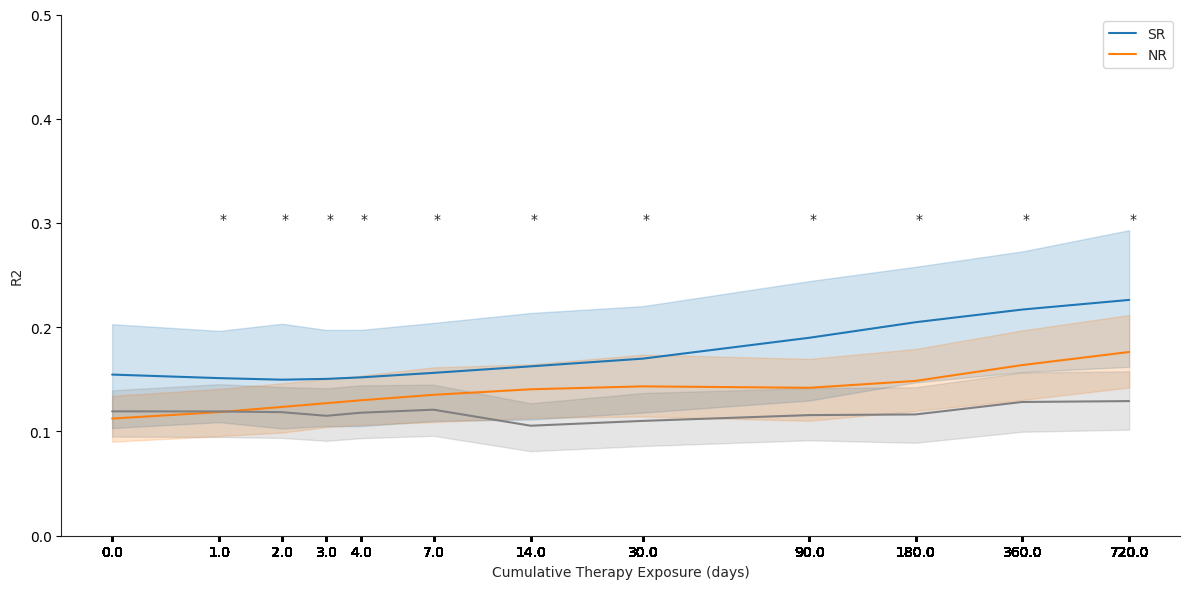

In [18]:
rank=3
despiked=False
X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))
X_NTF_Subject = X_NTF_Subject.groupby(['NP_code', 'model_name', 'Cumulative_Days'])['R2'].max().reset_index().set_index('NP_code')

combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(X_NTF_Subject)   
combined['R2'] = (combined['R2'].clip(lower=0, upper=1))
combined['log_Cumulative_Days'] = np.log10(combined['Cumulative_Days']+1)

combined_dose = combined[combined['model_name'] == 'Tx_WCE_Dose'].reset_index()
combined_dose_R = combined[combined['model_name'] == 'Tx_WCE_Dose_R'].reset_index()
combined_dose_R = combined_dose_R.loc[combined_dose.dropna().index]
combined_dose = combined_dose.dropna()

sig_str = np.array([(day, '*') if (sp_stats.wilcoxon(combined_dose[combined_dose['log_Cumulative_Days'] == day]['R2'],
                                                     combined_dose_R[combined_dose_R['log_Cumulative_Days'] == day]['R2'])[1]) < 0.05 else (day, ' ')
                    for day in combined_dose.log_Cumulative_Days.unique()])


true_diff = combined_dose.groupby('log_Cumulative_Days').apply(lambda x: (x[x['Responder_Type'] == 'SR']['R2'].mean() -
                                                                          x[x['Responder_Type'] == 'NR']['R2'].mean())).mean()
null_diff = []
for iii in range(1000):
    combined_dose_null = combined_dose.copy()
    combined_dose_null = combined_dose_null[combined_dose_null['Responder_Type'].isin(['SR', 'NR'])]
    combined_dose_null['Responder_Type'] = combined_dose_null['Responder_Type'].sample(frac=1).values
    
    null_diff.append(combined_dose_null.groupby('log_Cumulative_Days').apply(lambda x:
                                                                        (x[x['Responder_Type'] == 'SR']['R2'].mean() -
                                                                         x[x['Responder_Type'] == 'NR']['R2'].mean())).mean())
print('FDA-pvalue: {}'.format(np.mean(np.array(null_diff) > true_diff)))

plt.figure(figsize=(12,6), dpi=100)
ax = plt.subplot(111)
ax = sns.lineplot(x='log_Cumulative_Days', y='R2', data=combined_dose, hue='Responder_Type', hue_order=['SR', 'NR'], color='blue',
                  ci=68, estimator=np.mean, ax=ax);
ax = sns.lineplot(x='log_Cumulative_Days', y='R2', data=combined_dose_R, color='gray',
                  ci=68, estimator=np.mean, ax=ax);
for ss in sig_str:
    ax.text(float(ss[0]), 0.3, str(ss[1]))
ax.set_xticks(combined['log_Cumulative_Days'])
ax.set_xticklabels(combined['Cumulative_Days'])
ax.set_ylabel('R2')
ax.set_ylim([0, 0.5])
ax.set_xlabel('Cumulative Therapy Exposure (days)')
plt.tight_layout()
plt.savefig('{}/Cumulative_Therapy_Model_Fit-rank_{}-despiked_{}.svg'.format(fig_path, rank, despiked))
plt.show()

### Coefficients

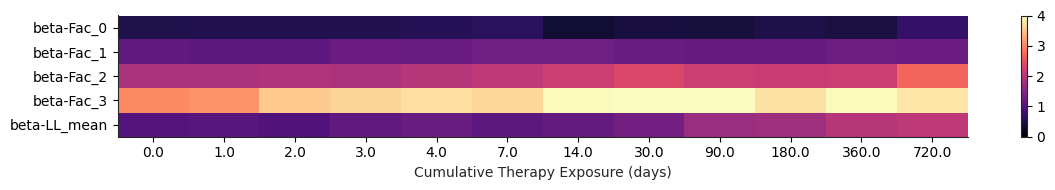

In [14]:
rank=3
despiked=False
X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))

combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(X_NTF_Subject).reset_index()

pred_list = []
for rnk in range(rank):
    pred_list.append('beta-Fac_{}'.format(rnk))
pred_list.append('beta-LL_mean')

combined_dose = combined.groupby(['NP_code', 'Cumulative_Days']).apply(lambda x: 
        ((x[x['model_name'] == 'Tx_WCE_Dose'][pred_list] - x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].mean()) / x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].std()))
combined_dose = combined_dose.reset_index().drop(columns='level_2')
combined_dose[pred_list] = np.abs(combined_dose[pred_list])

combined_dose[pred_list[:-1]] = combined_dose[pred_list[:-1]].apply(lambda x: np.sort(x.values), axis=1, result_type='broadcast')

dose_effect = combined_dose.groupby(['Cumulative_Days']).apply(lambda x: x[pred_list].median()).reset_index()


####
plt.figure(figsize=(12,2), dpi=100)
ax = plt.subplot(111)


mat = ax.imshow(dose_effect[pred_list].T, aspect='auto',
                vmin=0, vmax=4, cmap='magma', interpolation=None);
ax.set_xlabel('Cumulative Therapy Exposure (days)')
ax.set_xticks(np.arange(len(dose_effect['Cumulative_Days'].unique())))
ax.set_xticklabels(dose_effect['Cumulative_Days'].unique())
ax.set_yticks(range(len(pred_list)))
ax.set_yticklabels(pred_list)
plt.colorbar(mat, ax=ax)
plt.tight_layout()
plt.savefig('{}/Cumulative_Therapy_Beta_Coefs-rank_{}-despiked_{}.svg'.format(fig_path, rank, despiked))
plt.show()

### Spectral

[[9.60000000e+01 1.31397560e-02]
 [8.30915099e+01 9.72562291e-03]
 [7.19187397e+01 1.01900355e-02]
 [6.22482986e+01 9.45107277e-03]
 [5.38781783e+01 1.11114631e-02]
 [4.66335332e+01 1.11660006e-02]
 [4.03630279e+01 1.61892177e-02]
 [3.49356764e+01 1.83072631e-02]
 [3.02381052e+01 5.59235208e-02]
 [2.61721856e+01 1.17337830e-01]
 [2.26529835e+01 5.25995201e-01]
 [1.96069854e+01 8.55286275e-01]
 [1.69705627e+01 8.61603968e-01]
 [1.46886425e+01 5.84454050e-01]
 [1.27135571e+01 6.00876335e-01]
 [1.10040485e+01 9.48857248e-01]
 [9.52440631e+00 3.94618057e-01]
 [8.24372188e+00 1.58268645e-01]
 [7.13524269e+00 1.00576170e-01]
 [6.17581342e+00 1.18037732e-01]
 [5.34539231e+00 1.80088027e-01]
 [4.62663248e+00 3.28118005e-01]
 [4.00451956e+00 8.72935898e-01]
 [3.46605809e+00 8.37509092e-01]
 [3.00000000e+00 6.87522398e-01]]


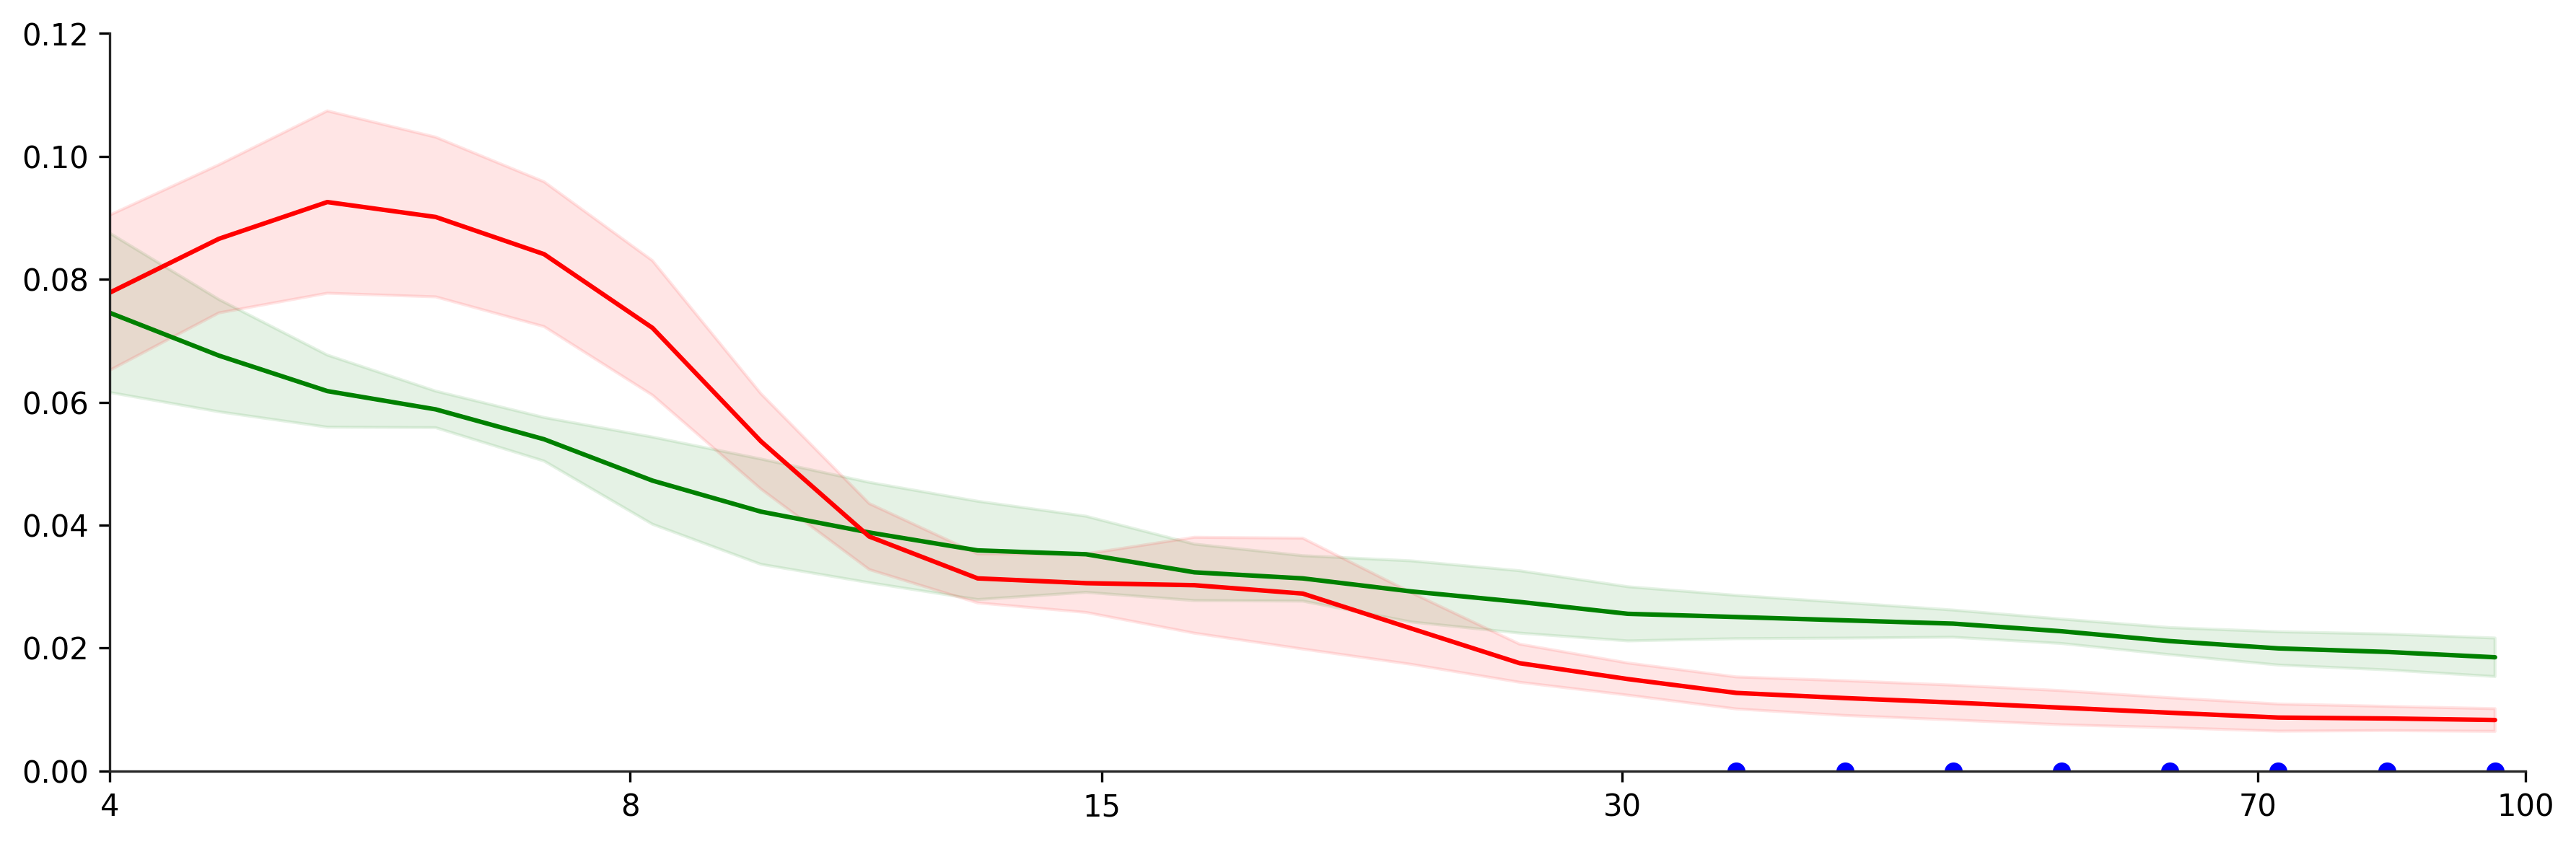

[[96.          0.81823693]
 [83.09150986  0.90570026]
 [71.91873969  0.92147714]
 [62.24829862  0.67173688]
 [53.87817832  0.64772973]
 [46.63353318  0.77582517]
 [40.36302793  0.7166869 ]
 [34.93567639  0.40392585]
 [30.2381052   0.25443434]
 [26.17218558  0.27282376]
 [22.6529835   0.29980438]
 [19.60698544  0.40661184]
 [16.97056275  0.77793846]
 [14.68864252  0.8294279 ]
 [12.71355713  0.73971986]
 [11.00404852  0.66359847]
 [ 9.52440631  0.48964117]
 [ 8.24372188  0.50937743]
 [ 7.13524269  0.67314461]
 [ 6.17581342  0.92493739]
 [ 5.34539231  0.939411  ]
 [ 4.62663248  0.94874394]
 [ 4.00451956  0.80227738]
 [ 3.46605809  0.4858239 ]
 [ 3.          0.44112759]]


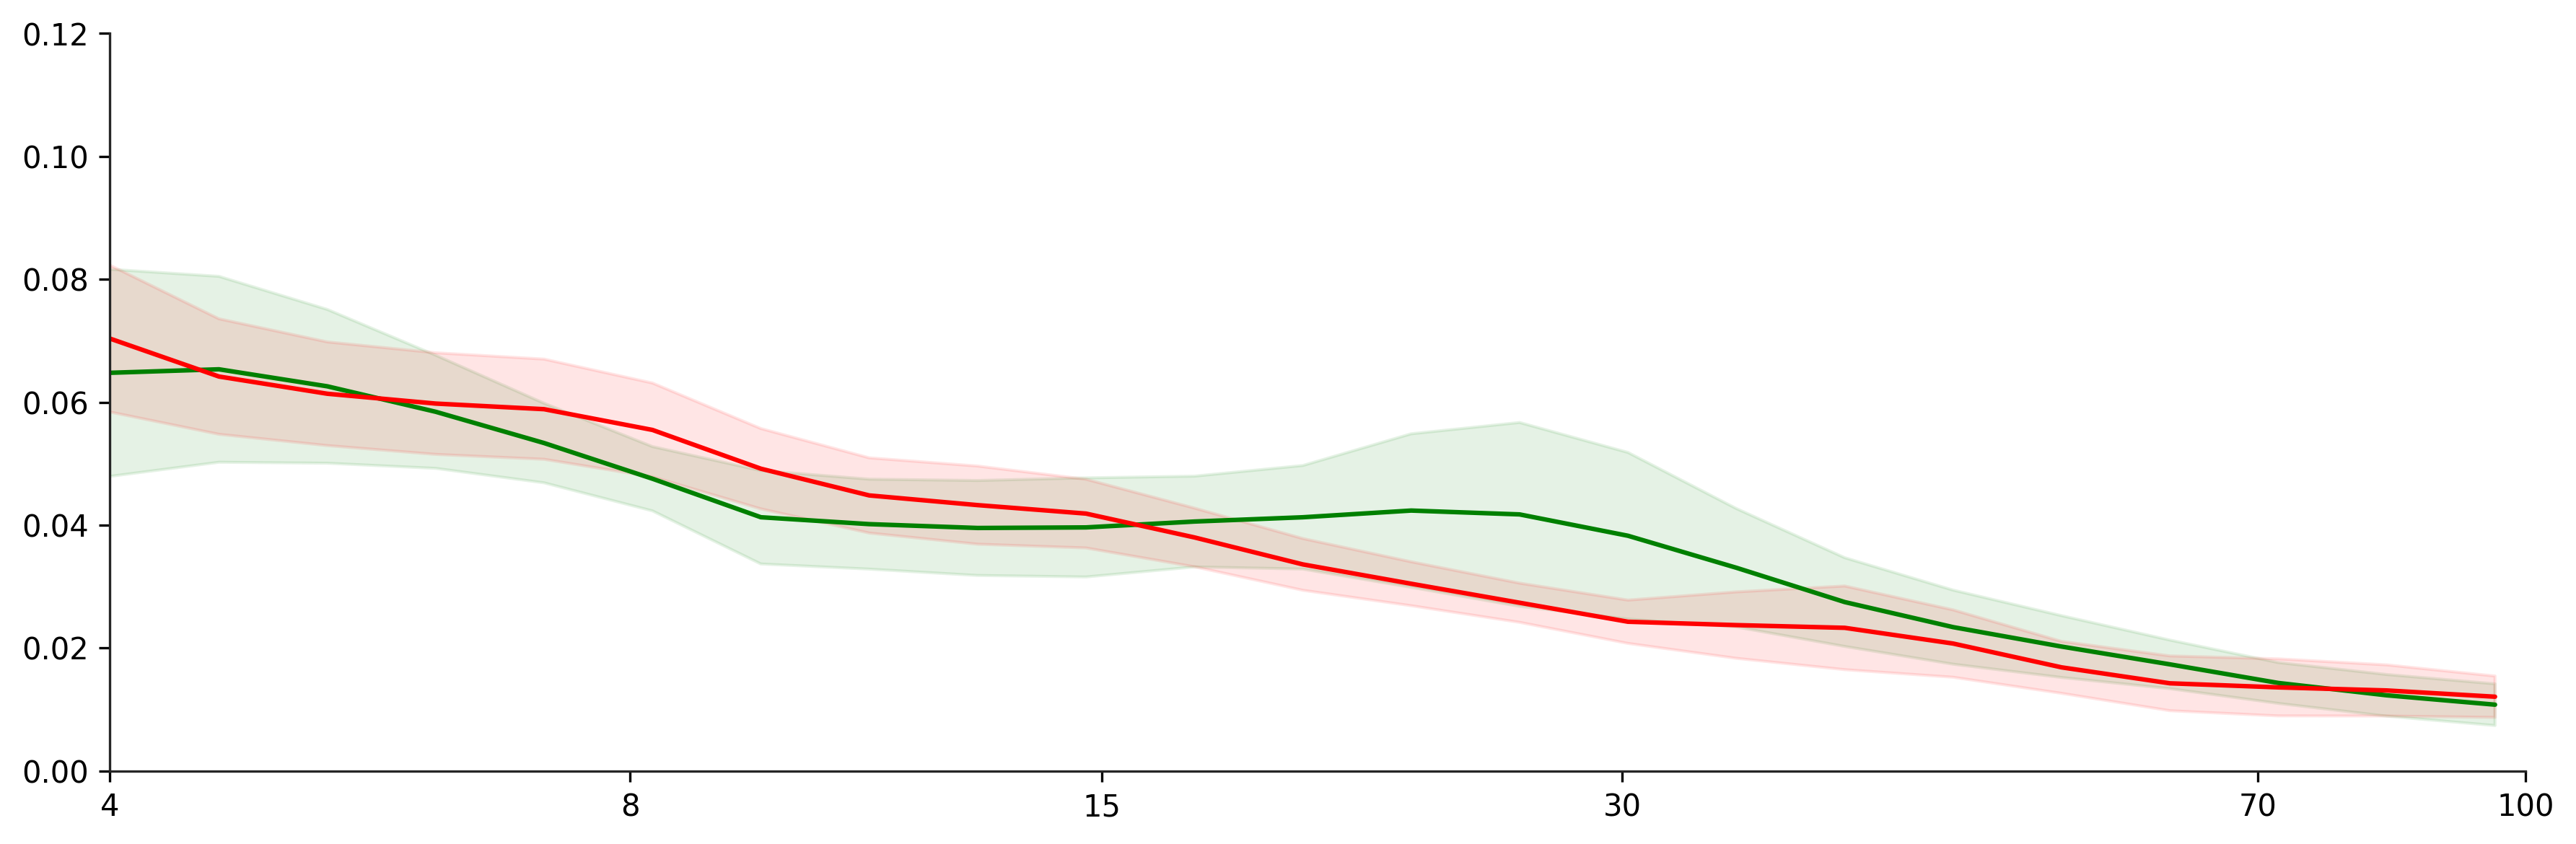

[[96.          0.39479802]
 [83.09150986  0.34037306]
 [71.91873969  0.37087164]
 [62.24829862  0.44358039]
 [53.87817832  0.48950433]
 [46.63353318  0.4716638 ]
 [40.36302793  0.54163893]
 [34.93567639  0.6711035 ]
 [30.2381052   0.93563147]
 [26.17218558  0.69085988]
 [22.6529835   0.59523451]
 [19.60698544  0.48368296]
 [16.97056275  0.32922279]
 [14.68864252  0.25604737]
 [12.71355713  0.26088369]
 [11.00404852  0.30000922]
 [ 9.52440631  0.52808035]
 [ 8.24372188  0.89630087]
 [ 7.13524269  0.54035343]
 [ 6.17581342  0.50532165]
 [ 5.34539231  0.73772555]
 [ 4.62663248  0.9159695 ]
 [ 4.00451956  0.91029997]
 [ 3.46605809  0.94107287]
 [ 3.          0.84667442]]


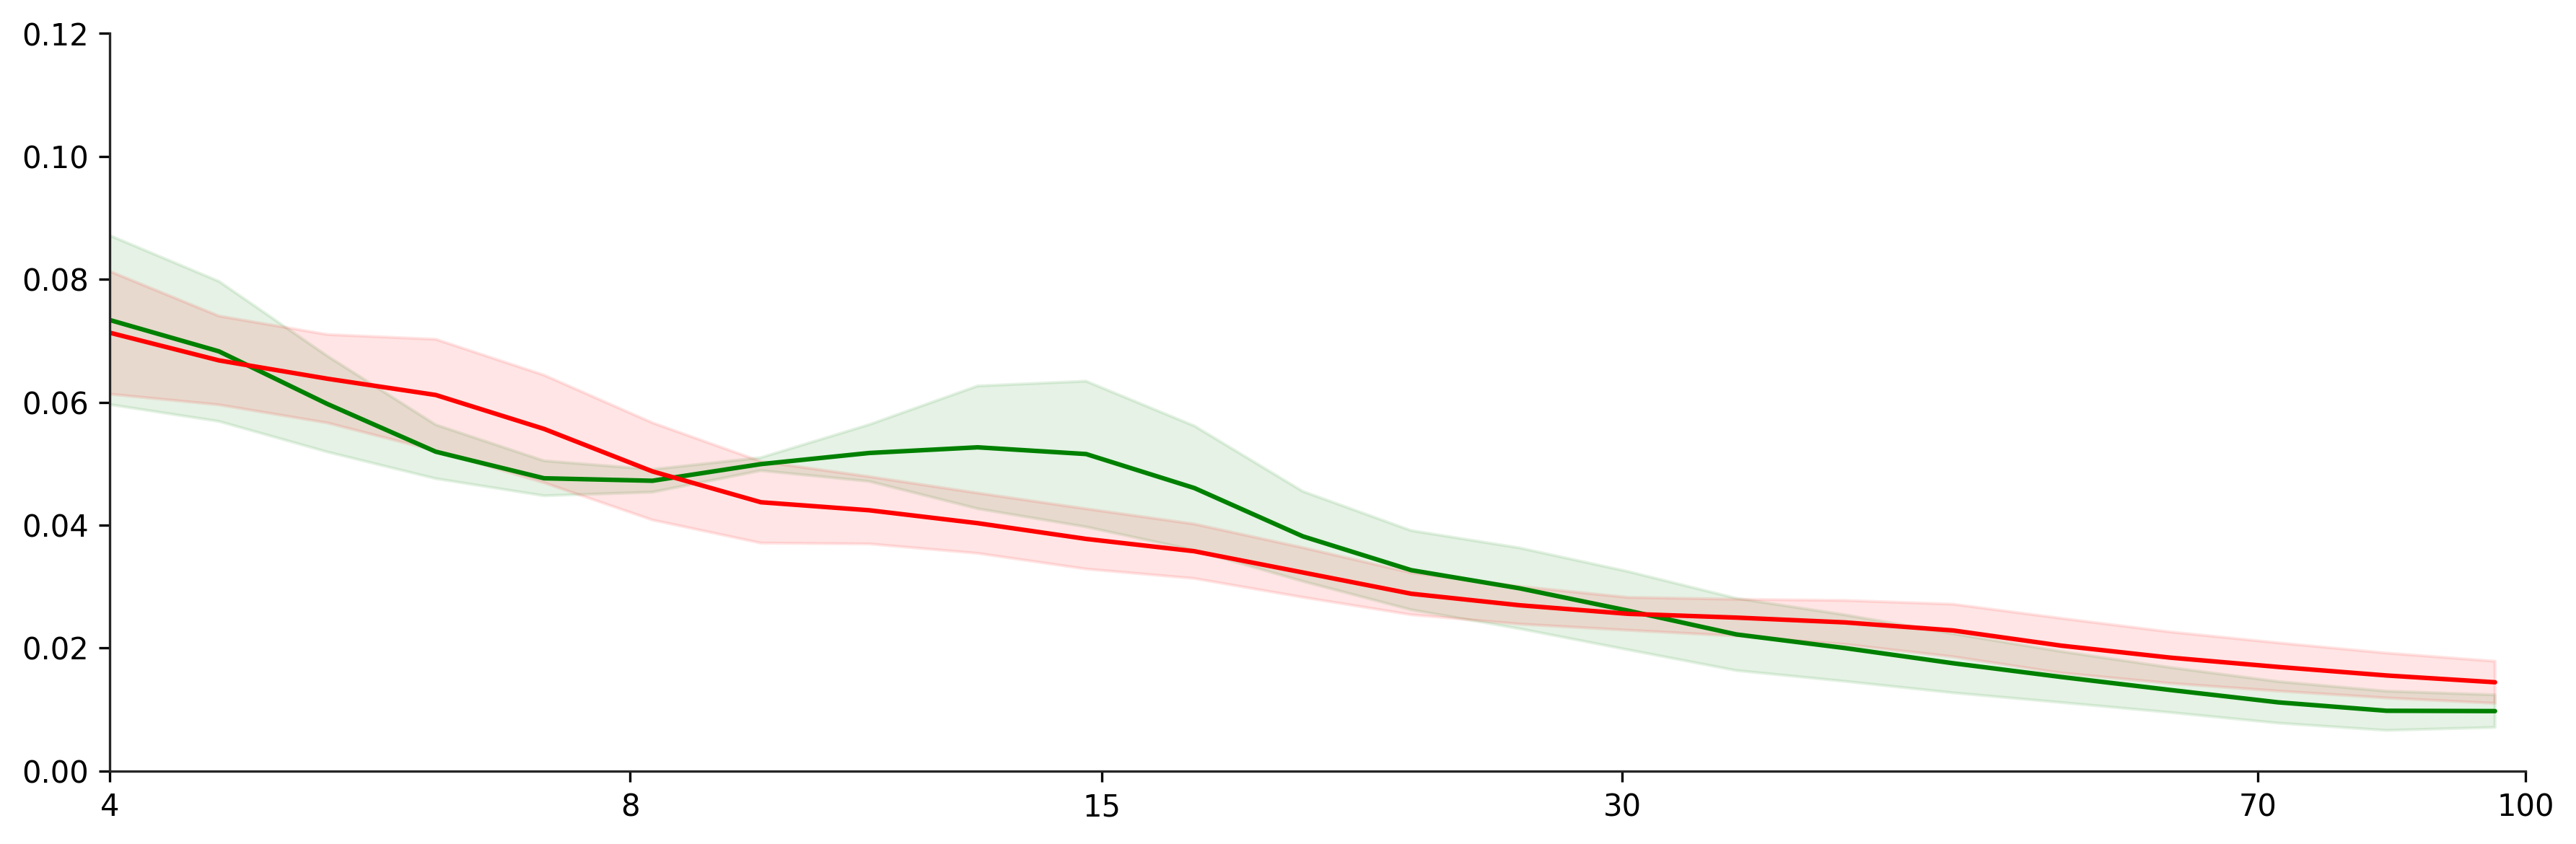

[[9.60000000e+01 1.59663809e-01]
 [8.30915099e+01 1.46736790e-01]
 [7.19187397e+01 1.33325399e-01]
 [6.22482986e+01 1.27700182e-01]
 [5.38781783e+01 1.95804469e-01]
 [4.66335332e+01 2.55074441e-01]
 [4.03630279e+01 3.62688404e-01]
 [3.49356764e+01 3.28497604e-01]
 [3.02381052e+01 6.08755767e-01]
 [2.61721856e+01 7.79555491e-01]
 [2.26529835e+01 7.29585787e-01]
 [1.96069854e+01 3.61528726e-01]
 [1.69705627e+01 1.36910024e-01]
 [1.46886425e+01 2.21386622e-02]
 [1.27135571e+01 1.41942530e-03]
 [1.10040485e+01 2.41675336e-03]
 [9.52440631e+00 2.00119502e-03]
 [8.24372188e+00 8.06812946e-04]
 [7.13524269e+00 1.55706253e-01]
 [6.17581342e+00 8.21398844e-01]
 [5.34539231e+00 4.63716671e-01]
 [4.62663248e+00 4.89274313e-02]
 [4.00451956e+00 1.47250542e-02]
 [3.46605809e+00 1.57820708e-02]
 [3.00000000e+00 7.76101901e-03]]


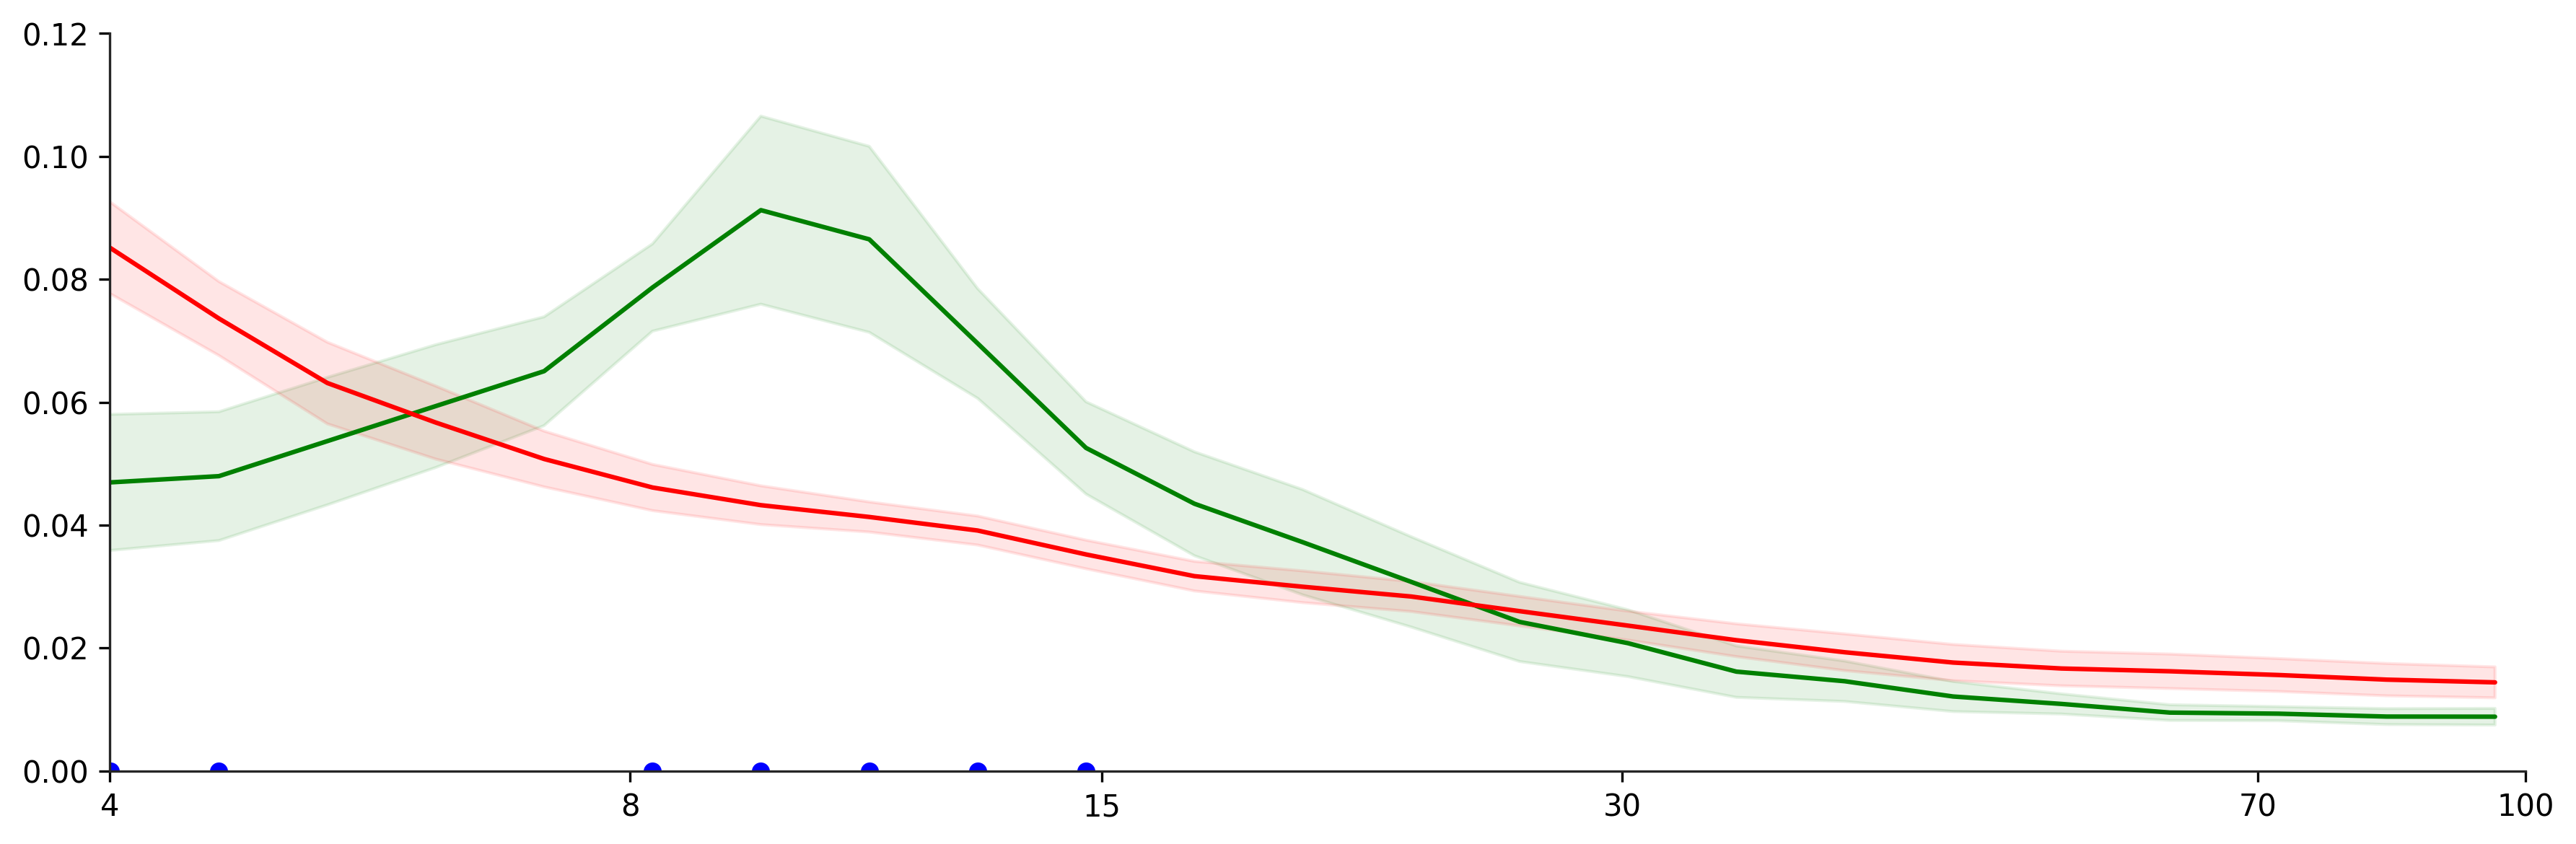

In [17]:
rank=3
despiked=False
X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))

pred_list = []
for rnk in range(rank):
    pred_list.append('beta-Fac_{}'.format(rnk))

combined = X_NTF_Subject.reset_index().groupby(['NP_code', 'Cumulative_Days']).apply(lambda x: 
        (x[x['model_name'] == 'Tx_WCE_Dose'][pred_list] - x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].mean()) / x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].std())
combined = combined.reset_index().drop(columns='level_2')
combined[pred_list] = np.abs(combined[pred_list])

combined[pred_list] = combined[pred_list].apply(lambda x: np.argsort(x.values), axis=1, result_type='broadcast').astype(int)
combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(combined.set_index('NP_code')).reset_index()

combined = combined[combined['Cumulative_Days'] > 0]


SPEC = {}
for rnk in range(rank):
    SPEC['Fac_{}'.format(rnk)] = []

for iii, ccc in combined.iterrows():
    
    W_time, W_freq, W_conn, n_exclude = e004_NTF.resample_NTF(
        ccc['NP_code'], metric='BIC', rank=rank, remove_blank=True, despiked=False)       

    for fac_i, fac in enumerate(pred_list):
        fac_j = int(ccc[fac])
        SPEC['Fac_{}'.format(fac_j)].append(W_freq['Fac_{}'.format(fac_i)].to_frame(ccc['NP_code']))

for key in SPEC:
    SPECTRAL = pd.concat(SPEC[key], axis=1)
    import numbers
    SPECTRAL = SPECTRAL.groupby(by=SPECTRAL.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])

    freqs = np.array(SPECTRAL.index)
    logfreqs = np.log10(freqs)
    sel_npref = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']]
    sel_npref = sel_npref[sel_npref['NP_code'].isin(SPECTRAL.columns)]  

    ####
    sel_npref = sel_npref[sel_npref['N_Vs_MT'].isin(['N', 'B'])]
    sel_npref = sel_npref[sel_npref['Responder_Type'].isin(['SR', 'IR', 'NR'])]

    SR_Subj = sel_npref[sel_npref['Responder_Type'] == 'SR']['NP_code']
    IR_Subj = sel_npref[sel_npref['Responder_Type'] == 'IR']['NP_code']
    NR_Subj = sel_npref[sel_npref['Responder_Type'] == 'NR']['NP_code']

    ####
    SR_mean = np.nanmean(SPECTRAL[SR_Subj], axis=1)
    SR_sem = np.nanstd(SPECTRAL[SR_Subj], axis=1) / np.sqrt(len(SR_Subj))
    
    IR_mean = np.nanmean(SPECTRAL[IR_Subj], axis=1)
    IR_sem = np.nanstd(SPECTRAL[IR_Subj], axis=1) / np.sqrt(len(IR_Subj))
    
    NR_mean = np.nanmean(SPECTRAL[NR_Subj], axis=1)
    NR_sem = np.nanstd(SPECTRAL[NR_Subj], axis=1) / np.sqrt(len(NR_Subj))

    #### T-Stat
    sig_fff = []
    for ii, ix in enumerate(SPECTRAL.index):
        try:
            tv, pv = sp_stats.ttest_ind(SPECTRAL[SR_Subj].loc[ix].dropna(),
                                        SPECTRAL[NR_Subj].loc[ix].dropna())

        except Exception as E:
            print(E)
            tv, pv = [0, 1]

        sig_fff.append([logfreqs[ii], pv])
    sig_fff = np.array(sig_fff)
    sig_fff2 = sig_fff.copy()
    sig_fff2[:, 0] = 10**(sig_fff2[:, 0])
    sig_fff = sig_fff[sig_fff[:,1] < 0.05][:, 0]

    #### Plot
    plt.figure(figsize=(12,4), dpi=300)
    ax = plt.subplot(1,1,1)  

    ax.plot(logfreqs, SR_mean, color='g')
    ax.fill_between(logfreqs, SR_mean-SR_sem, SR_mean+SR_sem, color='g', alpha=0.1)
    #ax.plot(logfreqs, IR_mean, color='orange')
    #ax.fill_between(logfreqs, IR_mean-IR_sem, IR_mean+IR_sem, color='orange', alpha=0.1)
    ax.plot(logfreqs, NR_mean, color='r')
    ax.fill_between(logfreqs, NR_mean-NR_sem, NR_mean+NR_sem, color='r', alpha=0.1)
    ax.scatter(sig_fff, np.zeros(len(sig_fff)), marker='.', color='b', s=100)

    freqs = np.array([4, 8, 15, 30, 70, 100])
    ax.set_xticks(np.log10(freqs))
    ax.set_xticklabels(freqs)
    ax.set_xlim([np.log10(freqs[0]), np.log10(freqs[-1])])
    ax.set_ylim([0, 0.12])
    plt.tight_layout()
    plt.savefig('{}/Spectral.Factors.M-{}-rank_{}-despiked_{}.svg'.format(fig_path, key, rank, despiked))
    plt.show()

### Spatial

Ttest_indResult(statistic=0.9001413389945411, pvalue=0.3763071804896282)


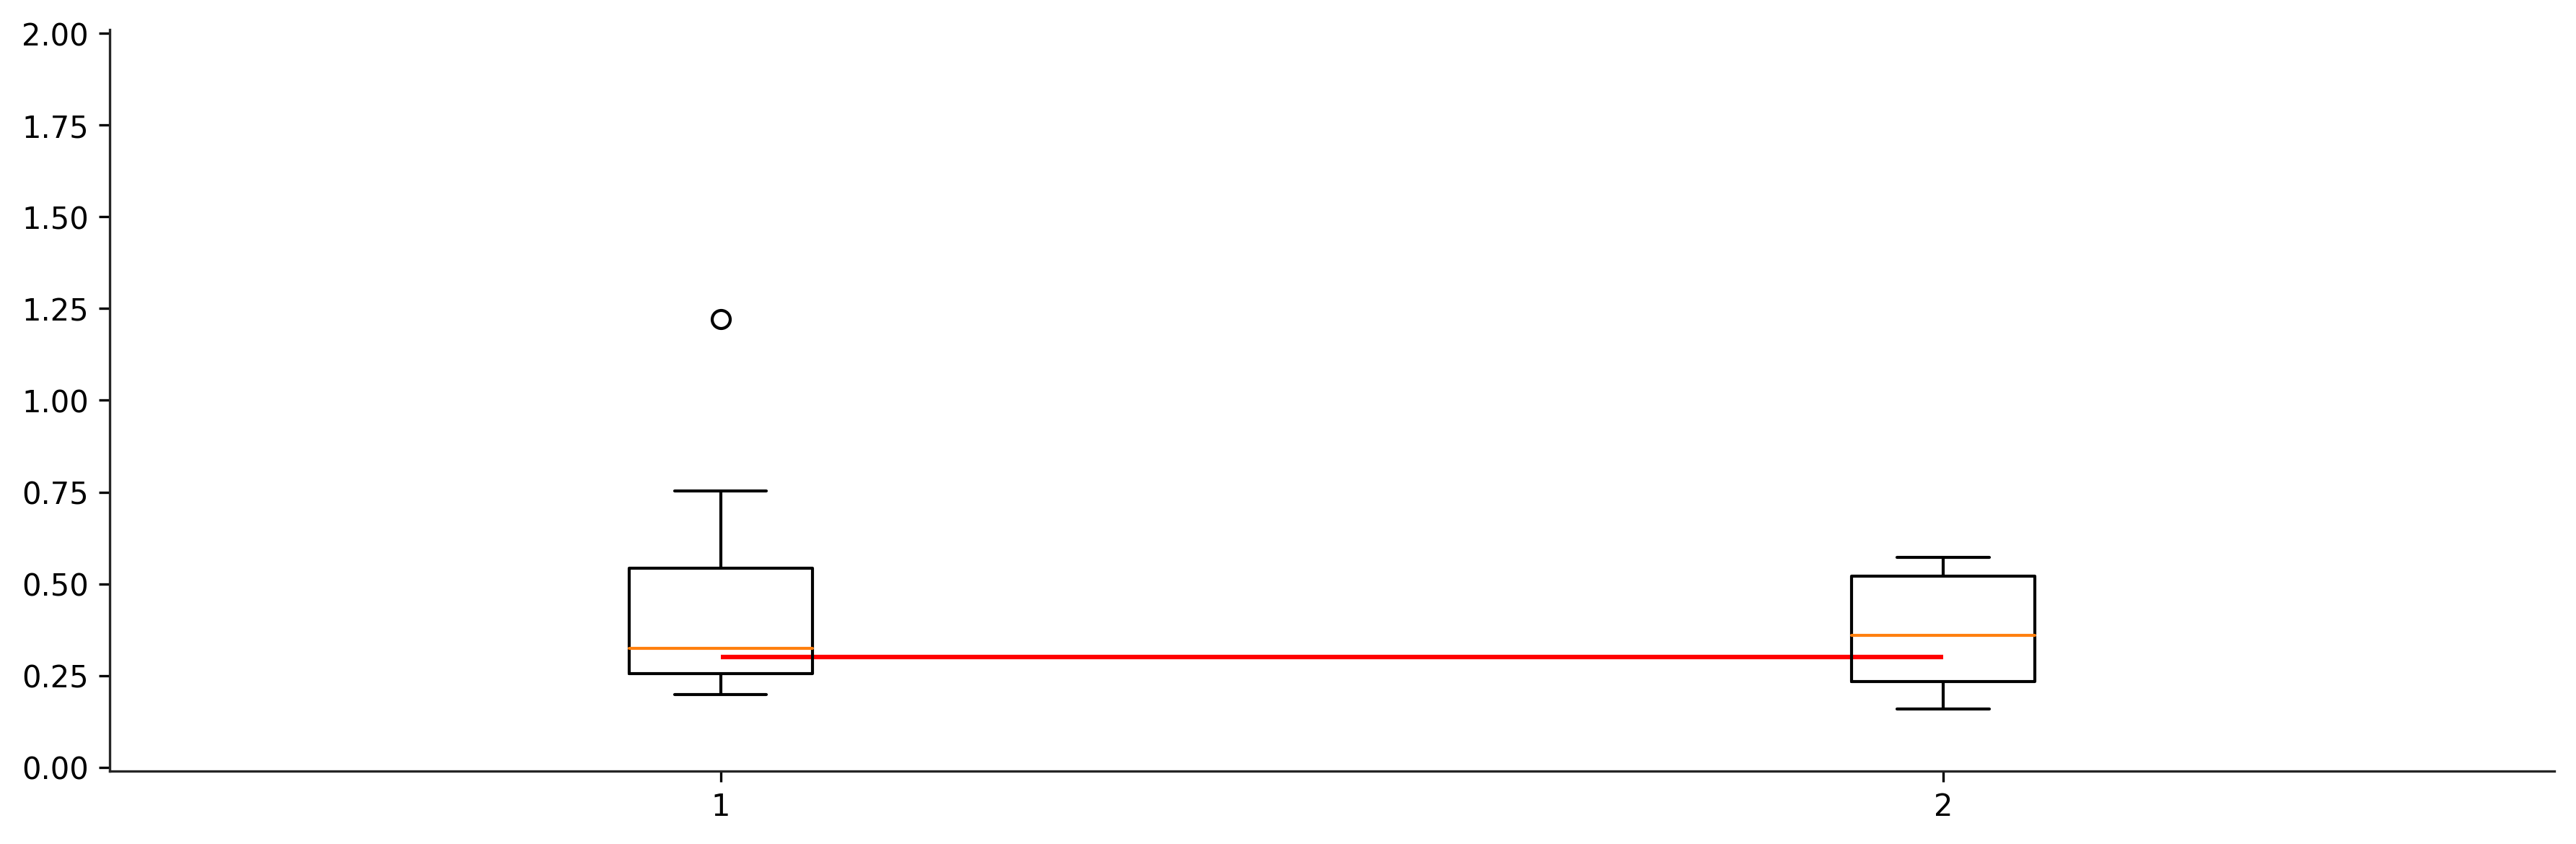

Ttest_indResult(statistic=-2.056333288684893, pvalue=0.049916866571614274)


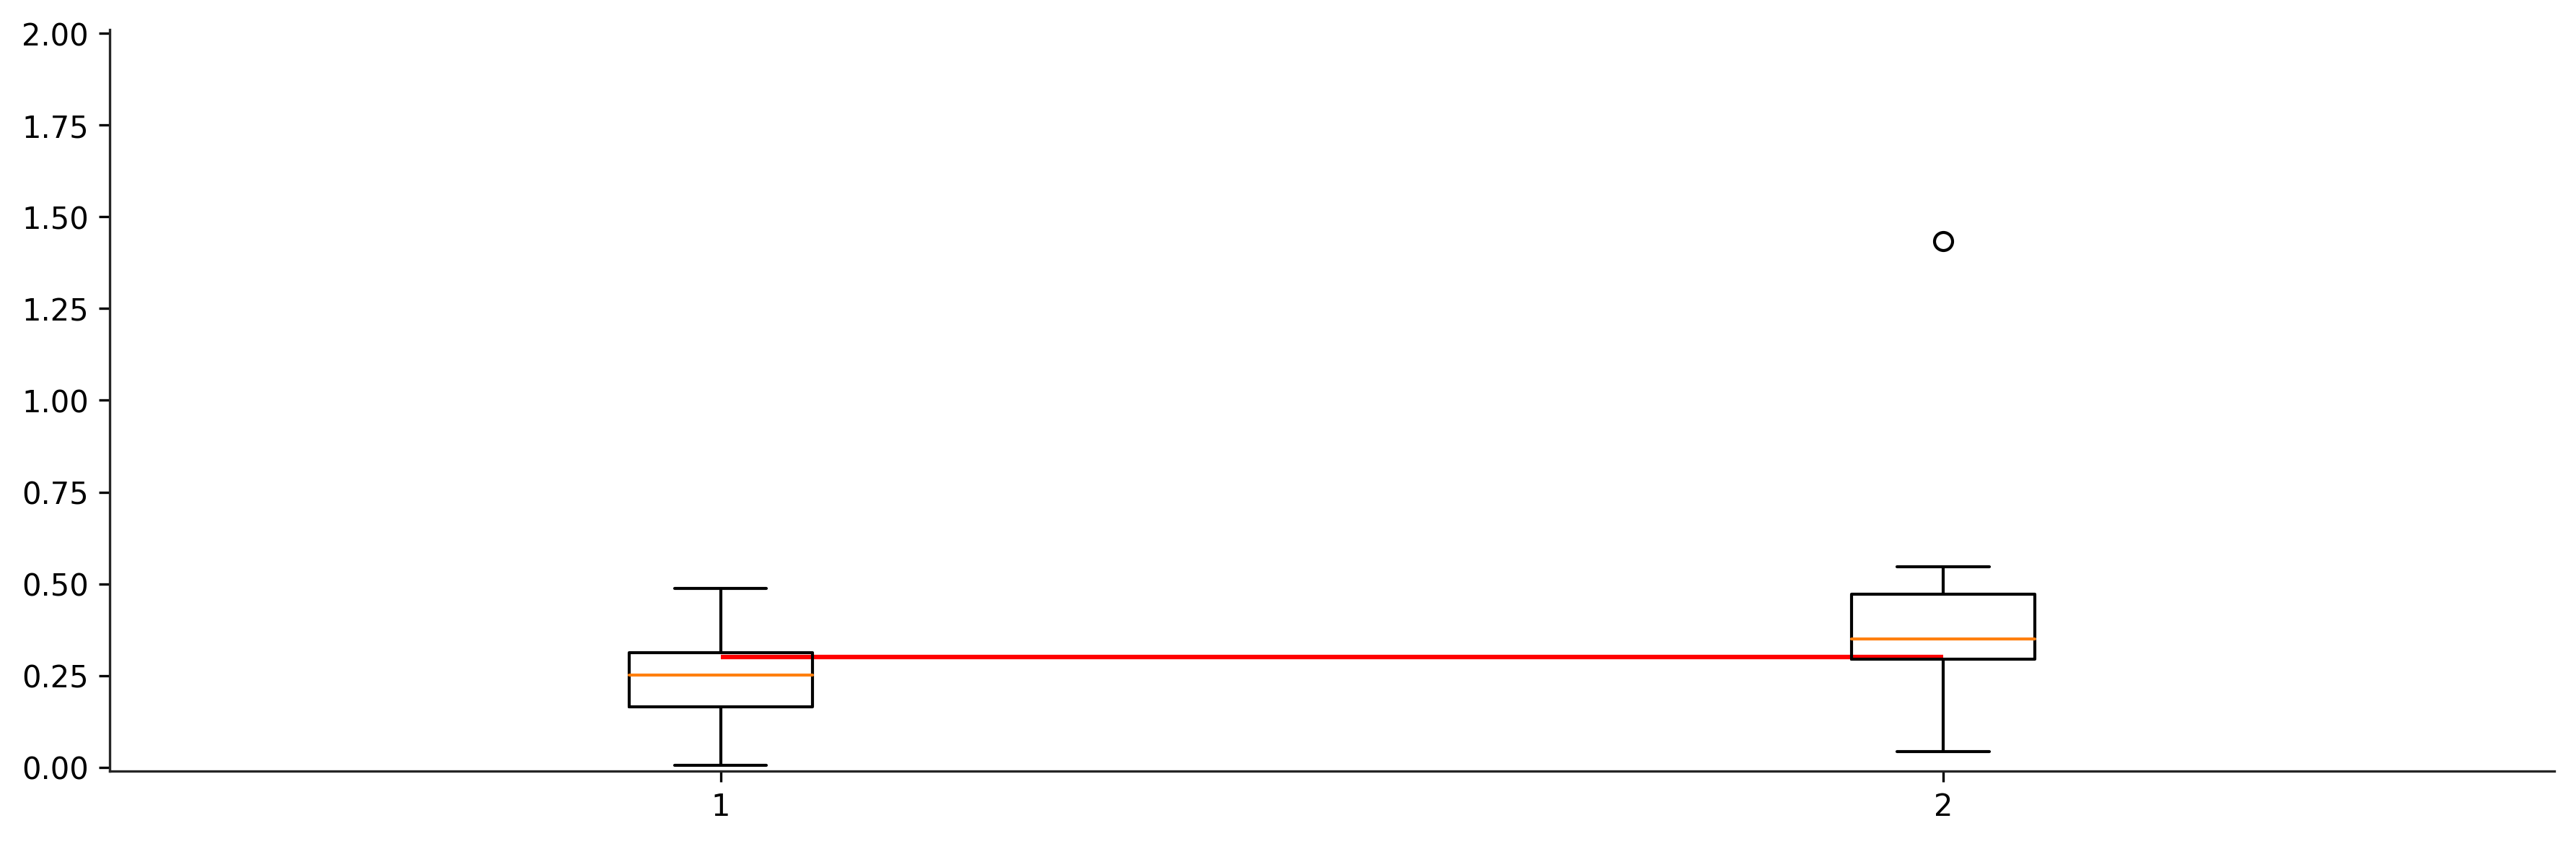

In [11]:
rank=3
despiked=False
X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))

pred_list = []
for rnk in range(rank):
    pred_list.append('beta-Fac_{}'.format(rnk))

combined = X_NTF_Subject.reset_index().groupby(['NP_code', 'Cumulative_Days']).apply(lambda x: 
        (x[x['model_name'] == 'Tx_WCE_Dose'][pred_list] - x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].mean()) / x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].std())
combined = combined.reset_index().drop(columns='level_2')
combined[pred_list] = np.abs(combined[pred_list])

combined[pred_list] = combined[pred_list].apply(lambda x: np.argsort(x.values), axis=1, result_type='broadcast').astype(int)
combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(combined.set_index('NP_code')).reset_index()

combined = combined[combined['Cumulative_Days'] > 0]

SPAT = {}
for rnk in range(rank):
    SPAT['Fac_{}'.format(rnk)] = []

for iii, ccc in combined.iterrows():
    
    if rank == 3:
        W_time, W_freq, W_conn, n_exclude = e004_NTF.resample_NTF(
            ccc['NP_code'], metric='BIC', rank=rank, remove_blank=True, despiked=False)
    else:
        W_time, W_freq, W_conn, n_exclude = e004_NTF.resample_NTF(
            ccc['NP_code'], metric='BIC', rank=rank, remove_blank=True, despiked=False)        

    for fac_i, fac in enumerate(pred_list):
        fac_j = int(ccc[fac])
        pval = np.sum(W_conn['Fac_{}'.format(fac_i)].values[1:-1])
        pval = np.abs(np.log10((pval) / (1-pval)))
        if np.isinf(pval):
            pval = 2.0
        SPAT['Fac_{}'.format(fac_j)].append(pd.DataFrame.from_dict({ccc['NP_code']: [pval]}))

for key in SPAT:
    SPECTRAL = pd.concat(SPAT[key], axis=1)
    import numbers
    SPECTRAL = SPECTRAL.groupby(by=SPECTRAL.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])

    sel_npref = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']]
    sel_npref = sel_npref[sel_npref['NP_code'].isin(SPECTRAL.columns)]  

    #### 
    sel_npref = sel_npref[sel_npref['N_Vs_MT'].isin(['N', 'B', 'M'])]
    sel_npref = sel_npref[sel_npref['Responder_Type'].isin(['SR', 'IR', 'NR'])]

    SR_Subj = sel_npref[sel_npref['Responder_Type'] == 'SR']['NP_code']
    IR_Subj = sel_npref[sel_npref['Responder_Type'] == 'IR']['NP_code']
    NR_Subj = sel_npref[sel_npref['Responder_Type'] == 'NR']['NP_code']

    print(sp_stats.ttest_ind(SPECTRAL[NR_Subj].values[0], SPECTRAL[SR_Subj].values[0]))

    #### Plot
    plt.figure(figsize=(12,4), dpi=300)
    ax = plt.subplot(1,1,1)  
    ax.boxplot([SPECTRAL[NR_Subj].values[0], SPECTRAL[SR_Subj].values[0]])
    ax.hlines(np.abs(np.log10((4/6) / (2/6))), 1, 2, color='r')
    ax.set_ylim([-0.01, 2.01])

    plt.tight_layout()
    plt.savefig('{}/Spatial.Factors.{}-rank_{}.svg'.format(fig_path, key, rank))
    plt.show()

### Time of Day

TOD
Daytime      (-1.0113681686514129, 0.31184025032995144)
Nighttime     (-0.30576246959228764, 0.759785505664706)
dtype: object


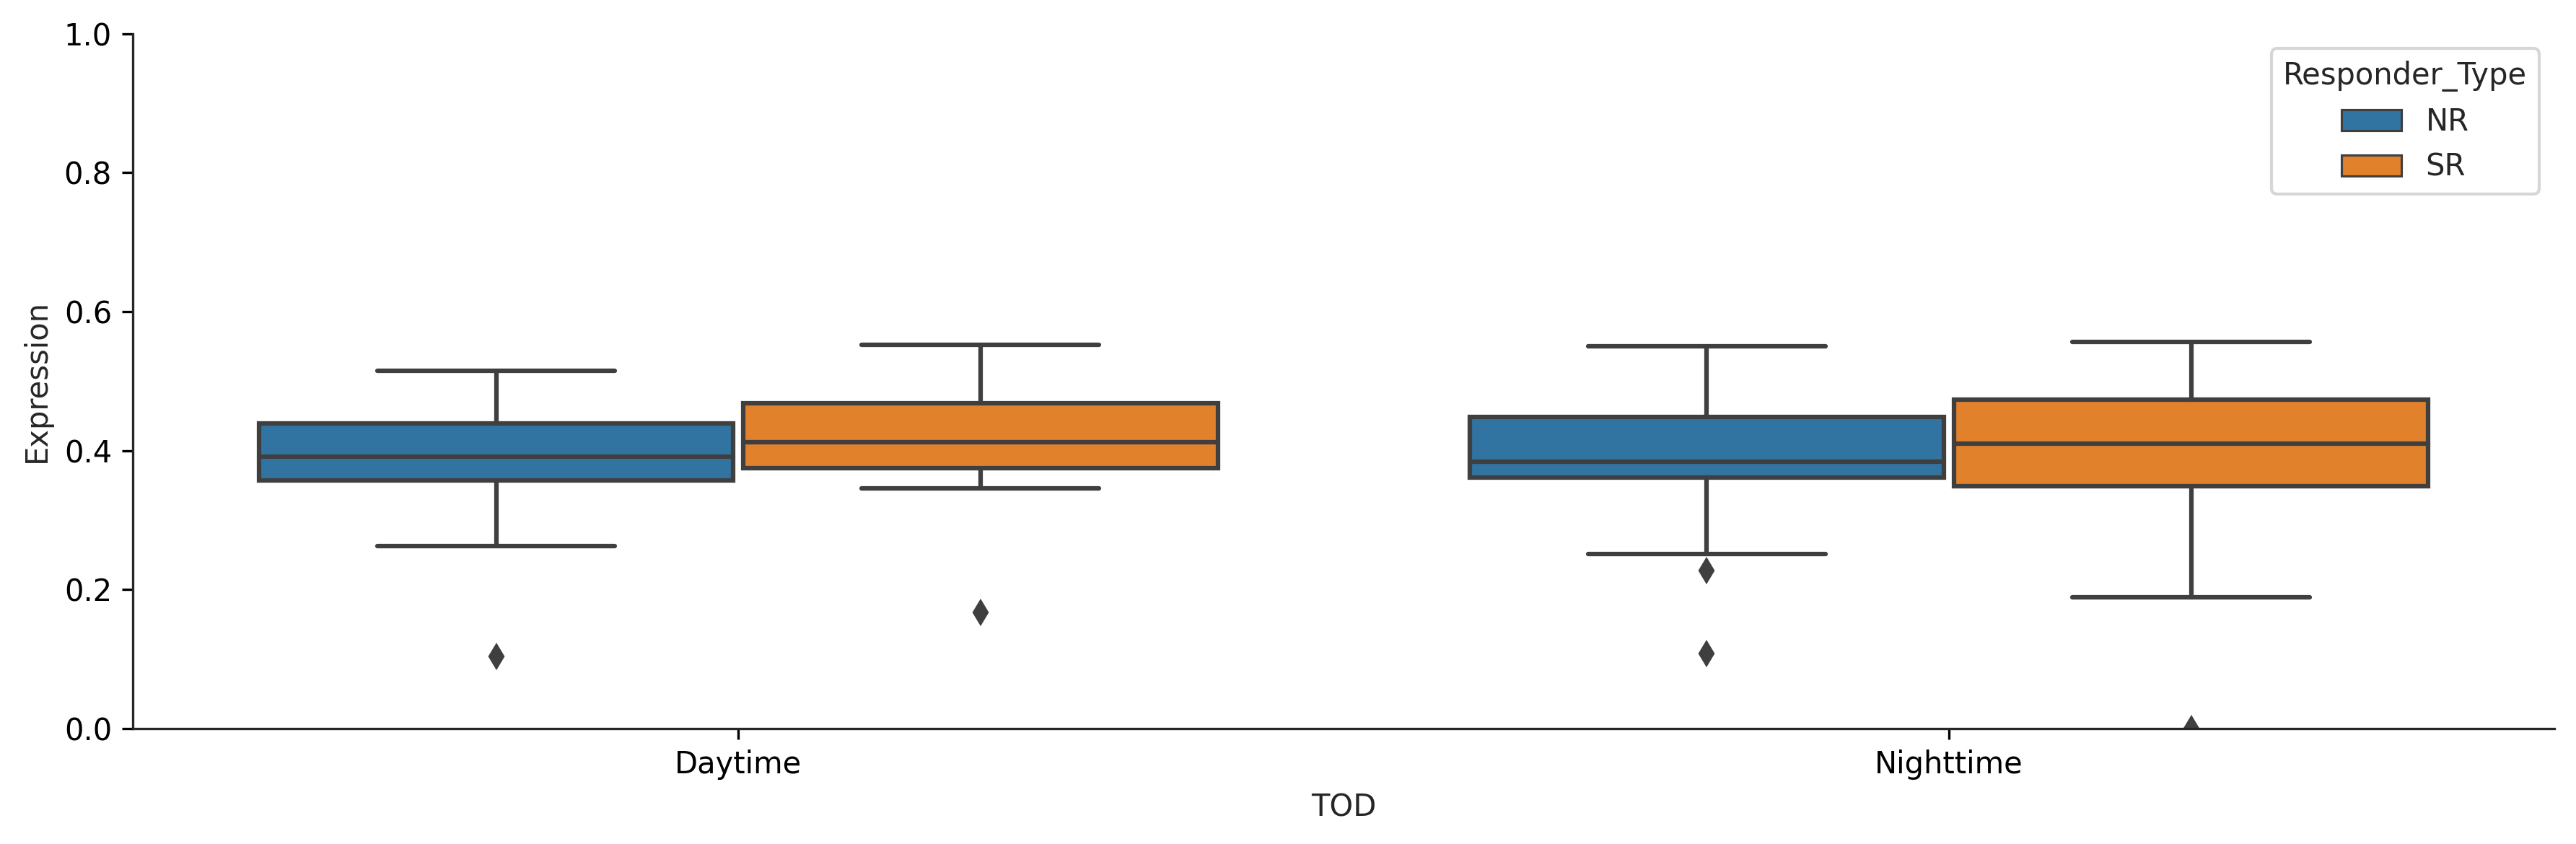

TOD
Daytime       (0.6820855090904878, 0.4951848829883486)
Nighttime    (0.8702470288395878, 0.38416542020497013)
dtype: object


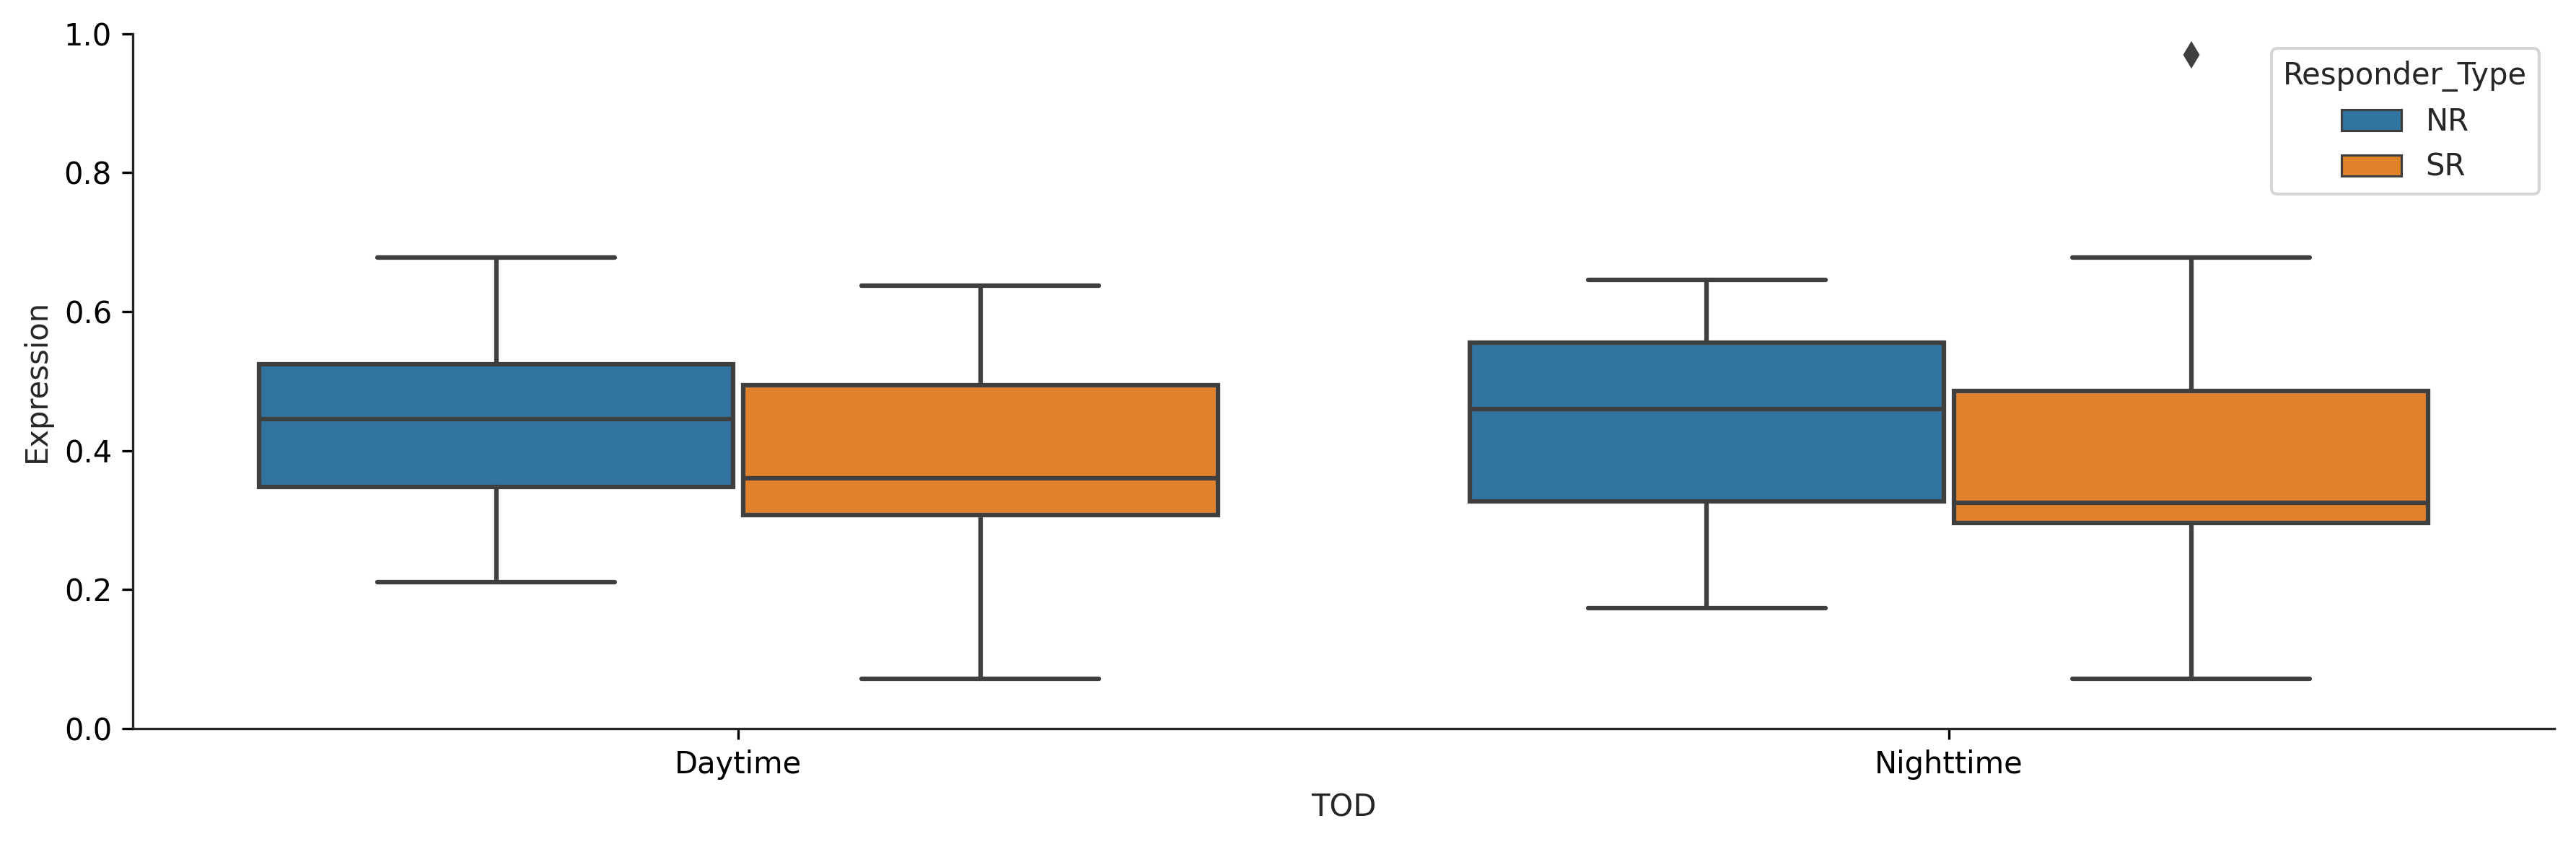

TOD
Daytime       (0.39984322946683765, 0.6892719882118307)
Nighttime    (-0.11760094984318754, 0.9063838523041351)
dtype: object


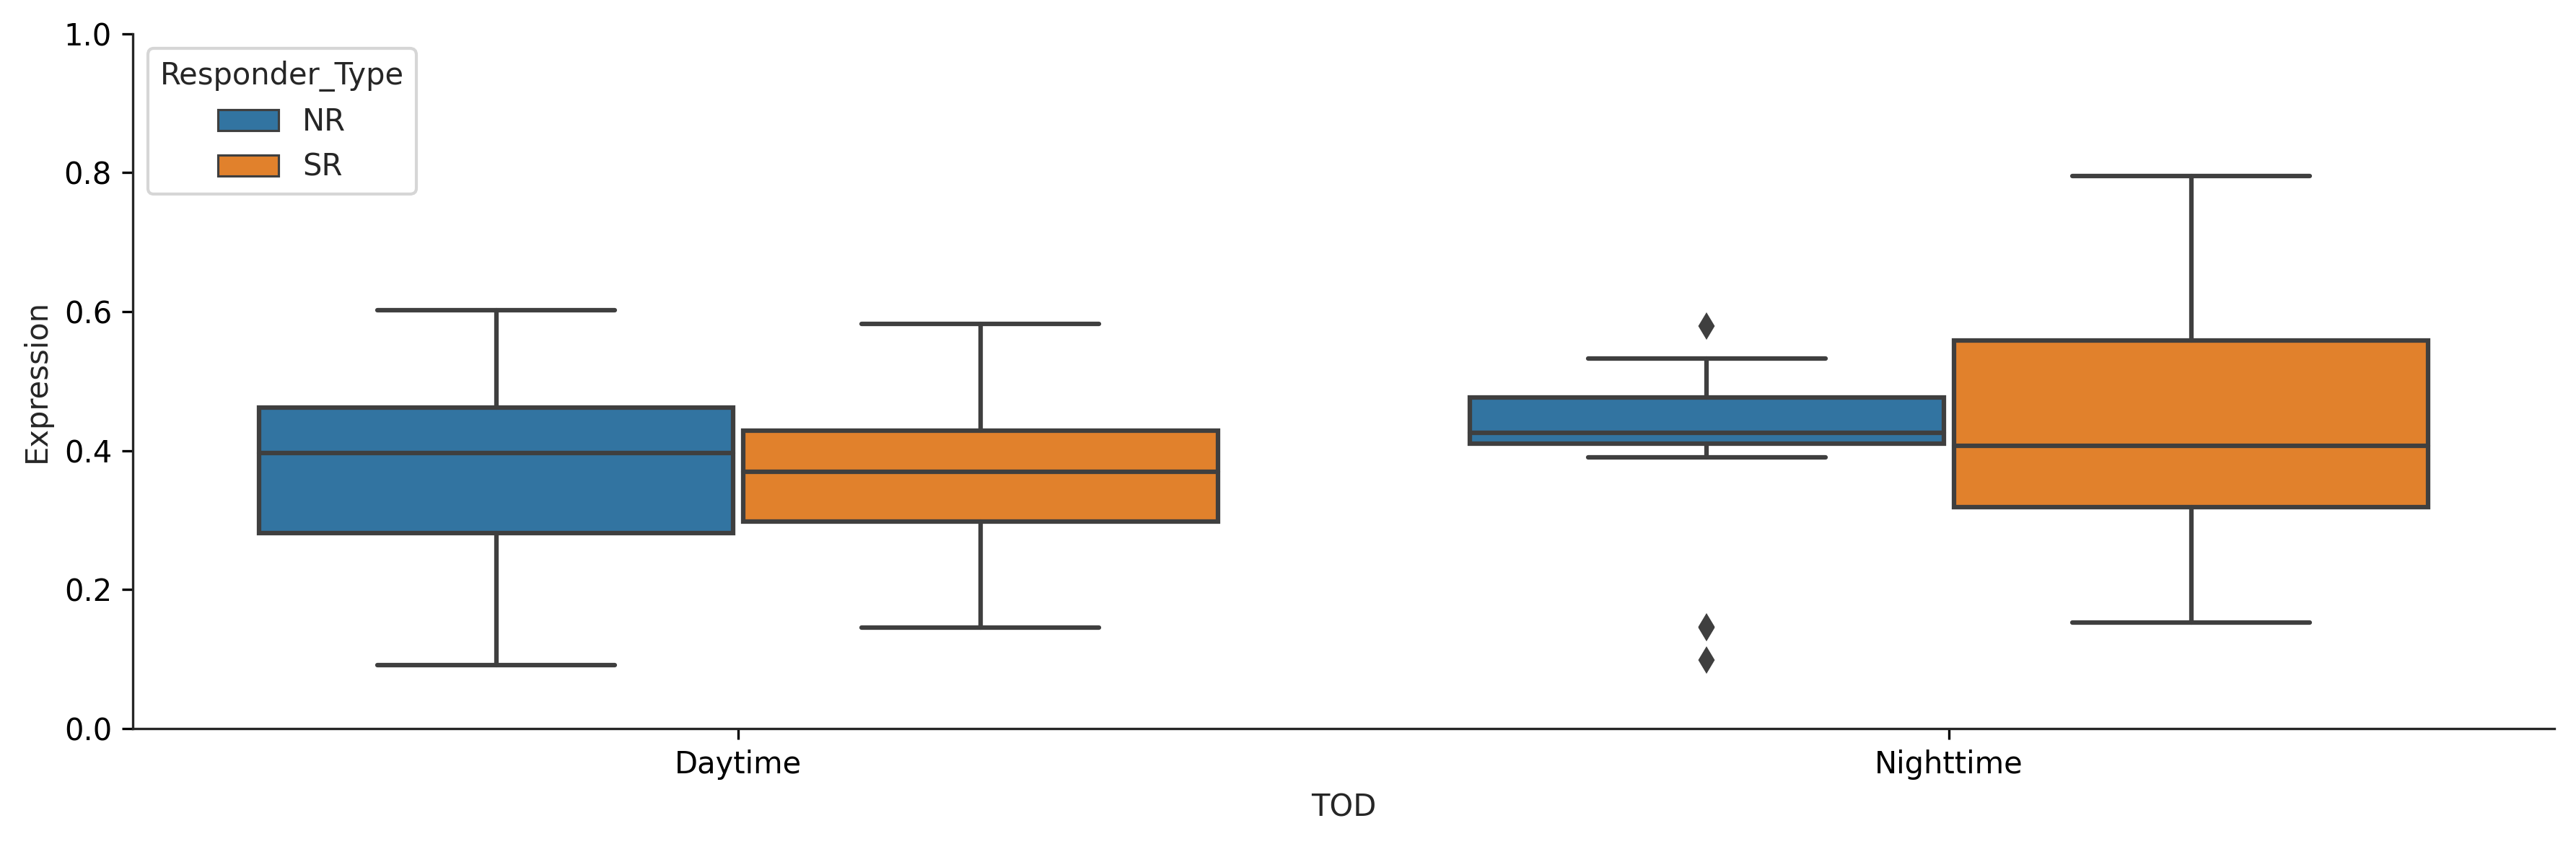

In [33]:
rank=3
despiked=False
X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects-rank_{}-despiked_{}.pkl'.format(cache_path, rank, despiked))

pred_list = []
for rnk in range(rank):
    pred_list.append('beta-Fac_{}'.format(rnk))

combined = X_NTF_Subject.reset_index().groupby(['NP_code', 'Cumulative_Days']).apply(lambda x: 
        (x[x['model_name'] == 'Tx_WCE_Dose'][pred_list] - x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].mean()) / x[x['model_name'] == 'Tx_WCE_Dose_R'][pred_list].std())
combined = combined.reset_index().drop(columns='level_2')
combined[pred_list] = np.abs(combined[pred_list])

combined[pred_list] = combined[pred_list].apply(lambda x: np.argsort(x.values), axis=1, result_type='broadcast').astype(int)
combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(combined.set_index('NP_code')).reset_index()

combined = combined[combined['Cumulative_Days'] > 0]

### TOD
TOD = {'NP_code': [], 'Factor': [], 'TOD': [], 'Expression': []}
for iii, ccc in combined.iterrows():

    X_daytime, X_nighttime = time_of_day_temporal_expression(ccc['NP_code'])

    for tod, X in [('Daytime', X_daytime),
                   ('Nighttime', X_nighttime)]:
        for fac_i, fac in enumerate(pred_list):
            fac_j = int(ccc[fac])
            TOD['NP_code'].append(ccc['NP_code'])
            TOD['Factor'].append('Fac_{}'.format(fac_j))
            TOD['TOD'].append(tod)
            TOD['Expression'].append(X['Fac_{}'.format(fac_j)])
TOD = pd.DataFrame.from_dict(TOD)
TOD = pd.merge(TOD, df_npref[['Responder_Type', 'NP_code']], on='NP_code') 
TOD2 = TOD.groupby(['NP_code', 'Factor', 'TOD', 'Responder_Type']).mean().reset_index()

for fac_id, df in TOD2.groupby(['Factor']):
    df2 = df[df['Responder_Type'].isin(['NR', 'SR'])]
    
    #### Plot
    plt.figure(figsize=(12,4), dpi=300)
    ax = plt.subplot(1,1,1)  
    
    ax = sns.boxplot(x='TOD', y='Expression', hue='Responder_Type', data=df2, ax=ax)
    
    print(df2.groupby(['TOD']).apply(lambda x: sp_stats.ranksums(
        x[x['Responder_Type'] == 'NR']['Expression'],
        x[x['Responder_Type'] == 'SR']['Expression'])))
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.savefig('{}/Time_of_Day.Factors.{}.svg'.format(fig_path, fac_id))
    plt.show()

## Electrographic Seizures Model

In [34]:
LE_PPV = pd.DataFrame.from_dict({'Initials': ['MR', 'GB', 'MM1', 'GK', 'CM (CS)'],
                                 'Date_LE_Stable': [pd.to_datetime('6/14/2016'),
                                                    pd.to_datetime('11/6/2018'),
                                                    pd.to_datetime('2/14/2018'),
                                                    pd.to_datetime('1/26/2016'),
                                                    pd.to_datetime('6/19/2018')]})
LE_PPV = pd.merge(LE_PPV, df_npref, on='Initials')

#### Plot



 NP46
1   155 days
Name: Date_LE_Stable, dtype: timedelta64[ns]


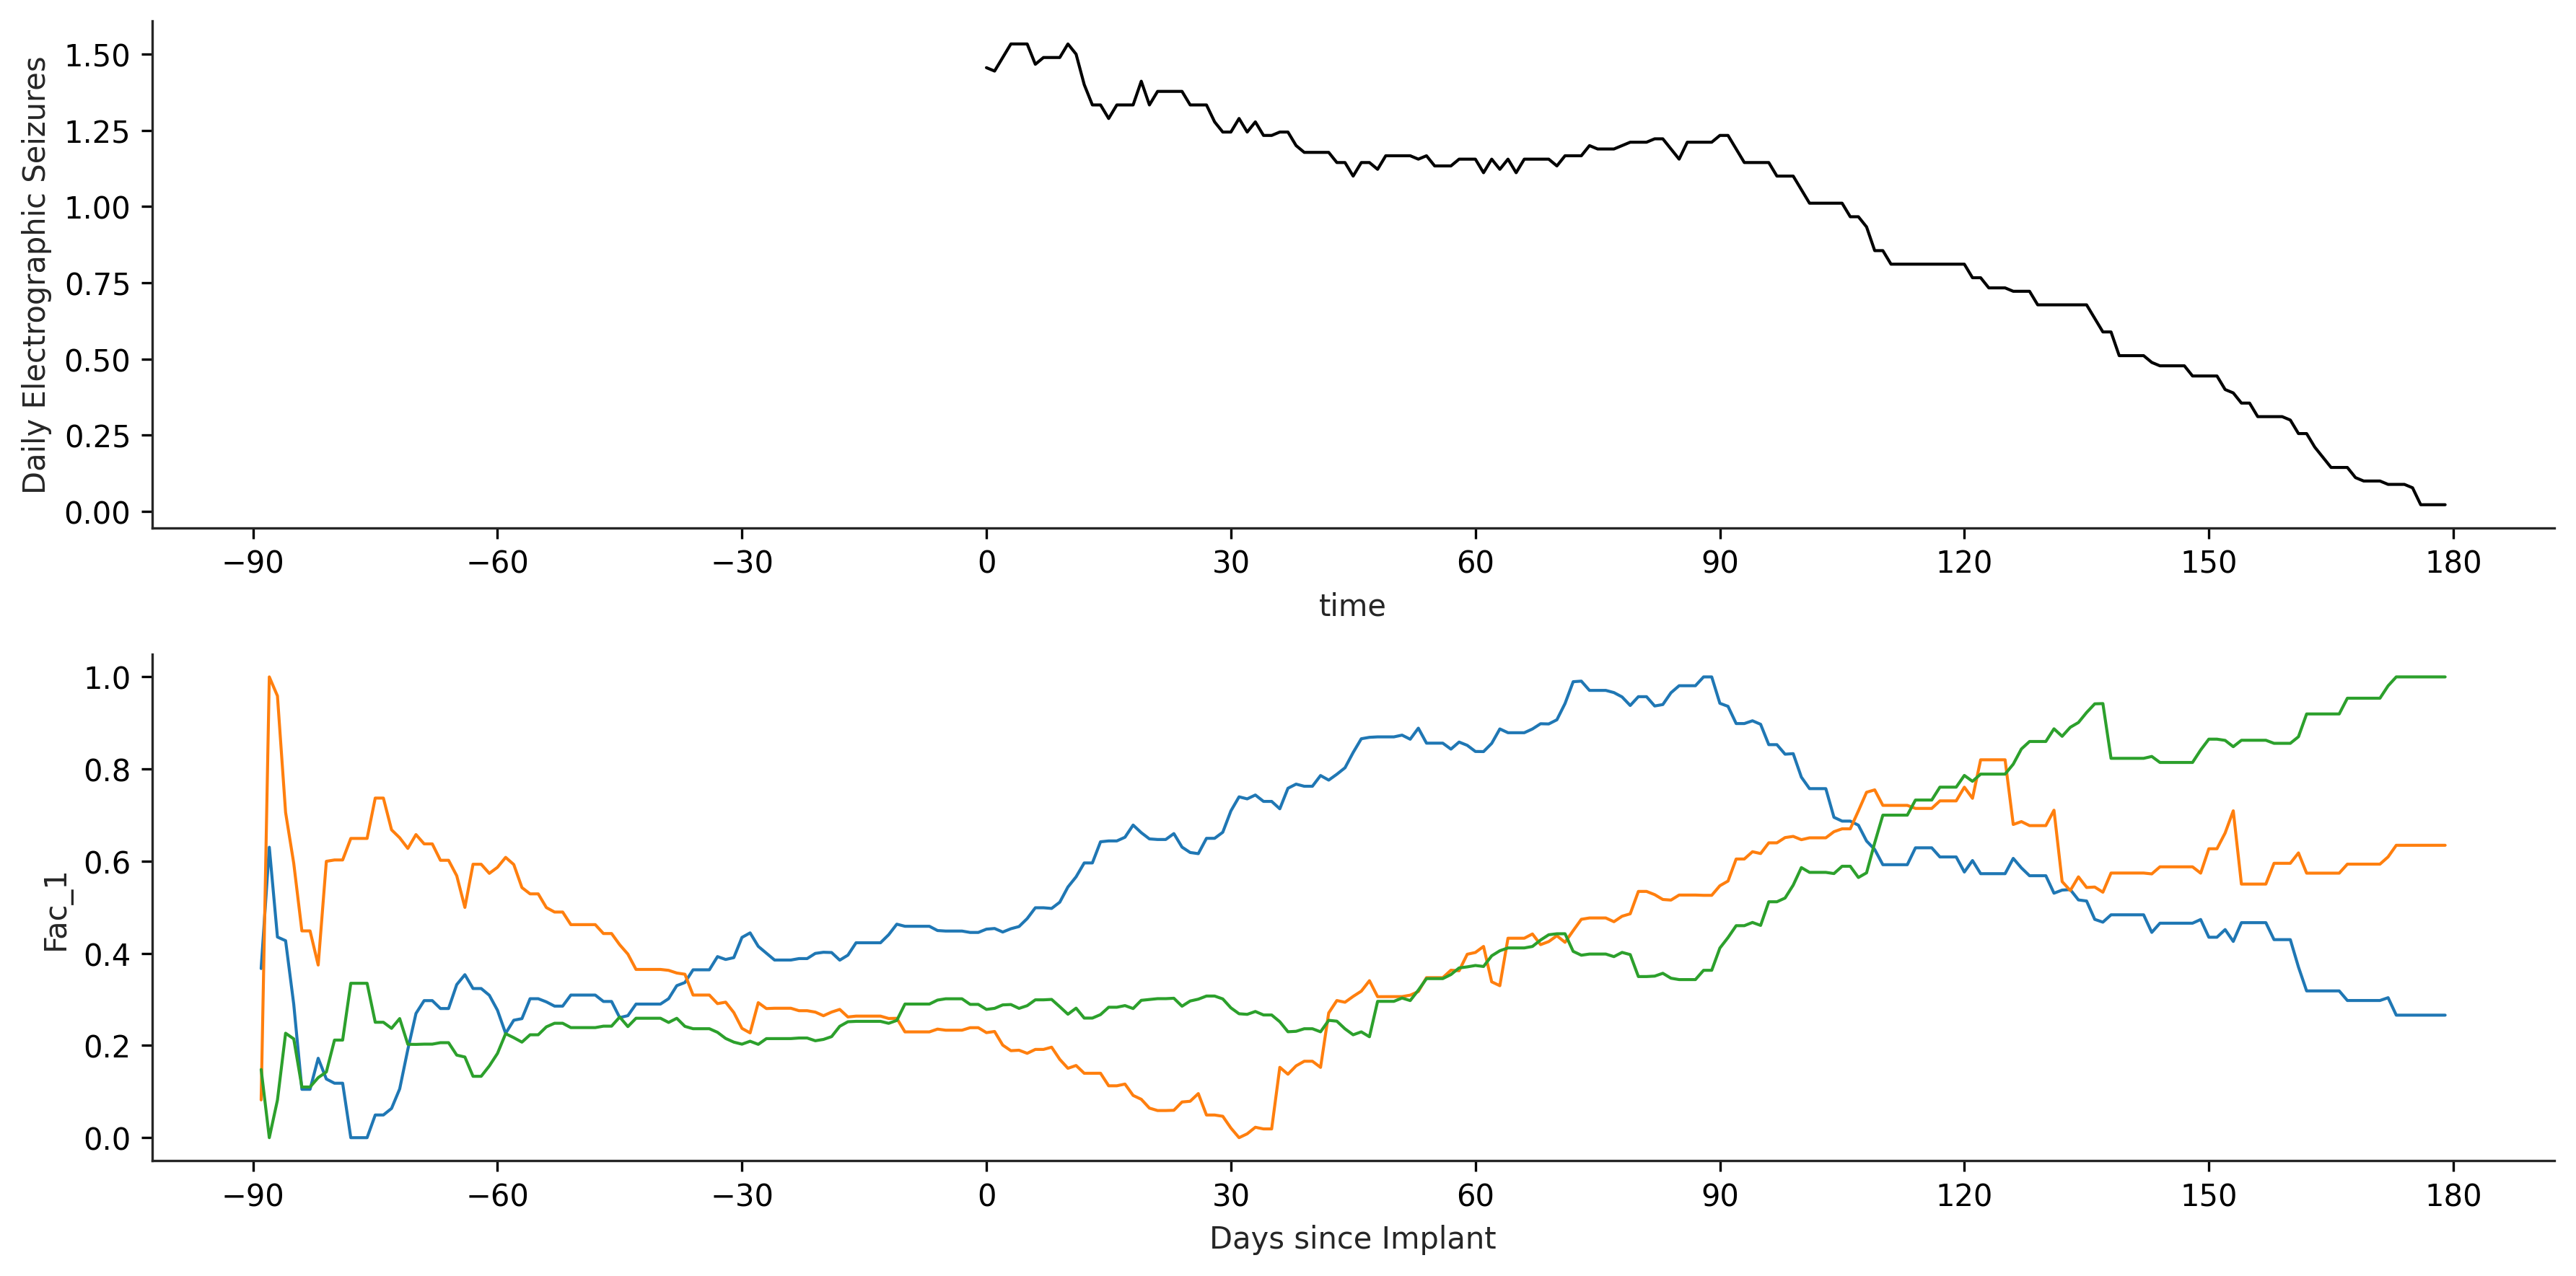

In [39]:
###
np_code = 'NP46'
X = plot_long_episodes(np_code, LE_PPV[LE_PPV['NP_code']==np_code]['Date_LE_Stable'], 90, 1)
X0 = X[0]
X1 = X[1]

X_NTF_Subject = pd.read_pickle('{}/Cumulative_Therapy_Effects.pkl'.format(cache_path))
combined = df_npref[['N_Vs_MT', 'Responder_Type', 'NP_code']].set_index('NP_code').join(X_NTF_Subject)
combined = combined.dropna()
combined = combined.groupby(['NP_code']).apply(lambda x: x[x['Cumulative_Days'] == 360])
combined = combined.reset_index(0).reset_index(drop=True)
ccc = combined[(combined['NP_code'] == np_code) &
               (combined['model_name'] == 'Tx_WCE_Dose')]

plt.figure(figsize=(12,6), dpi=300)
ax1 = plt.subplot(2,1,1)
ax1 = sns.lineplot(x='time', y='Dx_Current_LE', linewidth=1, color='k', data=X1, ax=ax1)
ax1.set_ylabel('Daily Electrographic Seizures')

ax2 = plt.subplot(2,1,2, sharex=ax1)
for fac in fac_col[ccc[['name-Fac_0', 'name-Fac_1', 'name-Fac_2']].astype(int).values][0]:
    ax2 = sns.lineplot(x='time', y=fac, linewidth=1, data=X0, ax=ax2)
ax2.set_xticks([-90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
ax2.set_xlabel('Days since Implant')

plt.tight_layout()
plt.savefig('{}/Electrographic_Sz-{}.svg'.format(fig_path, np_code))
plt.show()

### Build Model

In [41]:
from tqdm import tqdm

#NP46 -- 1 Month
#NP19 -- 
#NP9 -- 3 Months
#NP5 -- 3 Months

### Grab data for NP_code    
X_NTF_Subject = {'NP_code': [],
                 'lags': [],
                 'R2': [],
                 'deviance':[],
                 'nobs': [],
                 'df_model': [],                 
                 'isNull': [],
                 'model': []}

# Baseline Period
tscale = '30D'  
max_lags = 3
feats = ['Dx_Current_LE', 'Fac_0', 'Fac_1', 'Fac_2']
for np_code, le_ppv in LE_PPV[LE_PPV['NP_code'].isin(['NP1', 'NP5', 'NP9', 'NP19', 'NP46'])].groupby(['NP_code']):
    print('\n\n', np_code, flush=True)
    
    ###
    key_dates = extract_key_dates(np_code)
    stable_date = le_ppv['Date_LE_Stable']
    stable_days = stable_date - key_dates[0]
    stable_days = stable_days - max_lags*pd.Timedelta(tscale)

    # Remove observations preceding stable long-episodes parameters
    X1 = combine_temporal_features(np_code, rank=3, despiked=False)
    X1 = X1[X1.index >= stable_days.iloc[0]]  

    # Resample to Time-scale counts 
    X2 = X1.resample(tscale).mean()
    X2['Dx_Current_LE'] = X1.resample(tscale).sum()['Dx_Current_LE']
    X2['Tx_Current_Dose'] = X1.resample(tscale).sum()['Tx_Current_Dose']

    ### Create Lag DataFrame
    X3 = None
    columns = []
    lag_range = range(-max_lags, 1)
    for lll in lag_range:
        sl2 = slice(max_lags+lll, len(X2)+lll)
        if X3 is None:
            X3 = X2.iloc[sl2][feats].values
        else:
            X3 = np.concatenate((X3, X2.iloc[sl2][feats].values), axis=1)

        for fff in feats:
            columns.append('{}_L{}'.format(fff, np.abs(lll)))
    X3 = pd.DataFrame(X3, columns=columns).dropna()
    
    ### Evaluate models for each lag
    for lag in lag_range:
        
        # Select columns
        columns_all = []
        columns_pred = []

        columns_all.append('Dx_Current_LE_L0')
        for fff in feats:
            if (fff == 'Dx_Current_LE'):
                continue            
            columns_all.append('{}_L{}'.format(fff, np.abs(lag)))
            columns_pred.append('{}_L{}'.format(fff, np.abs(lag)))       
        
        columns_all = np.array(columns_all)
        columns_pred = np.array(columns_pred)
        X4 = X3[columns_all].copy()

        # Permute
        isNull = False
        for iii in tqdm(range(1001)):
            if iii > 0:
                X4[columns_pred] = X4[columns_pred].sample(frac=1).values
                isNull = True            
                
            # Run the model
            try:
                mdl_po, mdl_po_null = fit_longeps('Dx_Current_LE_L0', '+'.join(columns_pred), X4)
            except:
                continue

            YY = X4['Dx_Current_LE_L0']
            UU = mdl_po.predict(X4)
            UH = mdl_po_null.predict(X4)

            PR_true = 2*np.sum(YY * np.log(YY/UU) - (YY - UU))
            PR_null = 2*np.sum(YY * np.log(YY/UH) - (YY - UH))

            X_NTF_Subject['NP_code'].append(np_code)
            X_NTF_Subject['lags'].append(lag)
            X_NTF_Subject['R2'].append(1 - PR_true / PR_null)
            X_NTF_Subject['deviance'].append(PR_true)
            X_NTF_Subject['nobs'].append(mdl_po.nobs)
            X_NTF_Subject['df_model'].append(mdl_po.df_model)
            X_NTF_Subject['isNull'].append(isNull)
            X_NTF_Subject['model'].append(mdl_po)
            
X_NTF_Subject = pd.DataFrame.from_dict(X_NTF_Subject)
X_NTF_Subject



 NP1


100%|██████████| 1001/1001 [00:14<00:00, 68.83it/s]



 NP19



100%|██████████| 1001/1001 [00:14<00:00, 68.20it/s]



 NP46



100%|██████████| 1001/1001 [00:14<00:00, 66.96it/s]



 NP5



100%|██████████| 1001/1001 [00:15<00:00, 64.59it/s]



 NP9



100%|██████████| 1001/1001 [00:16<00:00, 62.36it/s]


,NP_code,lags,R2,deviance,nobs,df_model,isNull,model
0,NP1,-3,0.116891,36.335146,25,3,False,<statsmodels.genmod.generalized_linear_model.G...
1,NP1,-3,0.119604,36.223521,25,3,True,<statsmodels.genmod.generalized_linear_model.G...
2,NP1,-3,0.077795,37.943744,25,3,True,<statsmodels.genmod.generalized_linear_model.G...
3,NP1,-3,0.173302,34.014152,25,3,True,<statsmodels.genmod.generalized_linear_model.G...
4,NP1,-3,0.183580,33.591260,25,3,True,<statsmodels.genmod.generalized_linear_model.G...
...,...,...,...,...,...,...,...,...
20015,NP9,0,0.071304,66.567229,28,3,True,<statsmodels.genmod.generalized_linear_model.G...
20016,NP9,0,0.264947,52.687234,28,3,True,<statsmodels.genmod.generalized_linear_model.G...
20017,NP9,0,0.400724,42.955026,28,3,True,<statsmodels.genmod.generalized_linear_model.G...
20018,NP9,0,0.220291,55.888132,28,3,True,<statsmodels.genmod.generalized_linear_model.G...


### Trajectory + Correlation

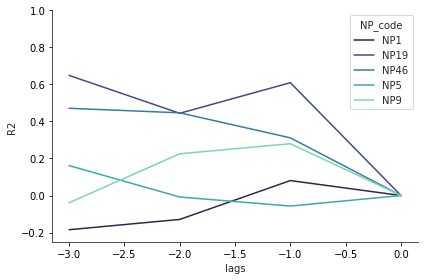

In [42]:
R2s = X_NTF_Subject.groupby(['NP_code', 'lags', 'isNull']).apply(
    lambda x: x['R2'].quantile(1.0) - X_NTF_Subject[(X_NTF_Subject['NP_code'] == x['NP_code'].values[0]) & 
                                                    (X_NTF_Subject['isNull'] == x['isNull'].values[0]) & 
                                                    (X_NTF_Subject['lags'] == 0)]['R2'].quantile(1.0)).reset_index()
R2s['R2'] = R2s[0]

plt.figure(figsize=(6,4))
palette = sns.color_palette("mako", 5)
ax = plt.subplot(111)
ax = sns.lineplot(x='lags', y='R2', hue='NP_code', data=R2s[~R2s['isNull']], ax=ax, palette=palette);
ax.set_ylim([-0.25, 1])
plt.tight_layout()
plt.savefig('{}/Long_Episode_Prediction.svg'.format(fig_path))
plt.show()